# Loan Data

## Context
This dataset consists of data from almost 10,000 borrowers that took loans - with some paid back and others still in progress. It was extracted from lendingclub.com which is an organization that connects borrowers with investors. We've included a few suggested questions at the end of this template to help you get started.

In [1]:
%%capture
pip install imblearn

In [2]:
%%capture
# Load packages

# Manipulate data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import time

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Components of models
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample,shuffle

# Evaluate result of models
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# Dealing with classification with imbalance classes
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

# Storing model
from joblib import Parallel, delayed 
import joblib

# Add plots to Jupyter notebook's file
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

cmap=sns.color_palette('Blues_r')

## Load your data

In [3]:
# Load data from the CSV file
df = pd.read_csv('history_loan_data.csv', index_col=None)

# Change the dots in the column names to underscores
df.columns = [col.replace(".", "_") for col in df.columns]
print(f"Number of rows / records: {df.shape[0]}")
print(f"Number of columns / variables: {df.shape[1]}")
df.head()

Number of rows / records: 9578
Number of columns / variables: 14


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


---- 

### 1. Executive summary   
According to a research by BCG, data analytics has been credited as 1 of the biggest drivers behind digital lending. The availability of data coupled with favorable regulatory environment is projected to enable nearly $1 trillion worth of digital loans to be disbursed in India alone in the next 5 years. For a digital lender to be competitive in the market, it must own the appropriate model to make lending decisions. Thus, based on the dataset which contains client credit record and loan history, we propose a model to predict the chances of a non-full payment from the client's loan. We first created a simple logistic regression model using features selected with RFE (and Random Forest and Gradient boosting as the underlying models). However, recall was low at 2% using this approach. Next, ‘stratified k-fold cross validation with SMOTE’ was applied during the model training to overcome issues with an imbalanced class.  Hyper-params were also fine-tuned using GridSearchCV. Recall then improved significantly to 61.2%. As a next step, we recommend researching more complex models like neural network to further improve the model and reduce the credit risk of the lender.


### 2. Business Problem and motivation  

For a digital lender to be profitable, it must not only have data strategy to acquire the data necessary for credit modelling, more importantly, such lenders must possess analytics models which allow it to make both lending decisions and monitor the financial health of its clients. In this report, we will attempt to create a model for digital lenders to make lending decisions based on the client data it has acquired. (McKinsey, 2021)

Our hypothesis is that based on the client's loan history and credit records, the lender will be able to predict the chances of a non-full payment from the client's loan. Such a predict can be further improved by perform vigorous feature selection using the RFE method with an ensemble model. In addition, by further fine tuning the model (by hyper-param tunning, SMOTE, k-fold cross validation), we can further improve the Recall of the model.  


### 3. Exploratory data analysis   
We first check for missing values in the dataset and noticed there is none.

In [4]:
# Create train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=0)
train, valid = train_test_split(df, test_size=0.2, random_state=0)
train.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
4247,1,major_purchase,0.0774,156.10,10.584056,10.27,797,5490.000000,2629,8.8,2,0,0,0
8766,0,all_other,0.1064,50.49,10.308953,15.60,697,6389.958333,1085,11.4,11,1,0,0
1509,1,debt_consolidation,0.1399,854.32,11.695247,19.76,692,3780.041667,41077,60.0,0,1,0,0
6120,1,debt_consolidation,0.1218,807.53,10.907386,17.41,737,4111.041667,28559,73.2,0,0,0,1
1069,1,debt_consolidation,0.1071,244.52,11.289682,13.02,702,3479.958333,8709,30.1,3,0,0,0


In [5]:
# Train: X and y split
X_train = train.drop('not_fully_paid', axis=1)
y_train = train[['not_fully_paid']]
X_train.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
4247,1,major_purchase,0.0774,156.10,10.584056,10.27,797,5490.000000,2629,8.8,2,0,0
8766,0,all_other,0.1064,50.49,10.308953,15.60,697,6389.958333,1085,11.4,11,1,0
1509,1,debt_consolidation,0.1399,854.32,11.695247,19.76,692,3780.041667,41077,60.0,0,1,0
6120,1,debt_consolidation,0.1218,807.53,10.907386,17.41,737,4111.041667,28559,73.2,0,0,0
1069,1,debt_consolidation,0.1071,244.52,11.289682,13.02,702,3479.958333,8709,30.1,3,0,0


In [6]:
y_train.head()

,not_fully_paid
4247,0
8766,0
1509,0
6120,1
1069,0


In [7]:
# Train: X and y split
X_test = test.drop('not_fully_paid', axis=1)
y_test = test[['not_fully_paid']]
X_test.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
3343,1,all_other,0.1189,49.75,10.829729,16.87,687,2314.958333,962,64.1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0
1741,1,debt_consolidation,0.1695,712.54,11.918391,13.61,672,4830.041667,16473,94.1,2,2,0
5160,1,debt_consolidation,0.1739,286.78,11.189962,19.59,667,7020.000000,19892,67.0,1,0,1
7760,0,credit_card,0.1312,202.51,9.392662,4.40,657,898.958333,5251,49.3,9,0,0


In [8]:
# Valid: X and y split
X_valid = valid.drop('not_fully_paid', axis=1)
y_valid = test[['not_fully_paid']]
X_valid.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
3343,1,all_other,0.1189,49.75,10.829729,16.87,687,2314.958333,962,64.1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0
1741,1,debt_consolidation,0.1695,712.54,11.918391,13.61,672,4830.041667,16473,94.1,2,2,0
5160,1,debt_consolidation,0.1739,286.78,11.189962,19.59,667,7020.000000,19892,67.0,1,0,1
7760,0,credit_card,0.1312,202.51,9.392662,4.40,657,898.958333,5251,49.3,9,0,0


In [9]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int_rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log_annual_inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days_with_cr_line  9578 non-null   float64
 8   revol_bal          9578 non-null   int64  
 9   revol_util         9578 non-null   float64
 10  inq_last_6mths     9578 non-null   int64  
 11  delinq_2yrs        9578 non-null   int64  
 12  pub_rec            9578 non-null   int64  
 13  not_fully_paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [10]:
# Split columns by data type
num = ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
non_num = ['purpose']

Next, we check the distribution of the numerical values to see if there's outliers or skewed distribution.   

### 3.1. Numerical features 

In [11]:
# Check distribution of num values
X_train[num].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
count,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7.662000e+03,7662.000000,7662.000000,7662.000000,7662.000000
mean,0.805664,0.122471,319.821534,10.942256,12.532610,711.070086,4588.193955,1.720949e+04,46.793504,1.582485,0.163665,0.064866
std,0.395714,0.026808,207.166705,0.613794,6.889475,37.914312,2536.972522,3.501028e+04,29.021155,2.197629,0.551577,0.270066
min,0.000000,0.060000,15.690000,7.600902,0.000000,612.000000,180.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103450,164.320000,10.571317,7.140000,682.000000,2820.000000,3.180250e+03,22.325000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,269.070000,10.933107,12.580000,707.000000,4140.000000,8.596000e+03,46.300000,1.000000,0.000000,0.000000
75%,1.000000,0.139200,434.352500,11.314475,17.857500,737.000000,5760.041667,1.847525e+04,71.000000,2.000000,0.000000,0.000000
max,1.000000,0.216400,926.830000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,108.800000,33.000000,13.000000,5.000000


=== Distribution of features (before log transformation) ===


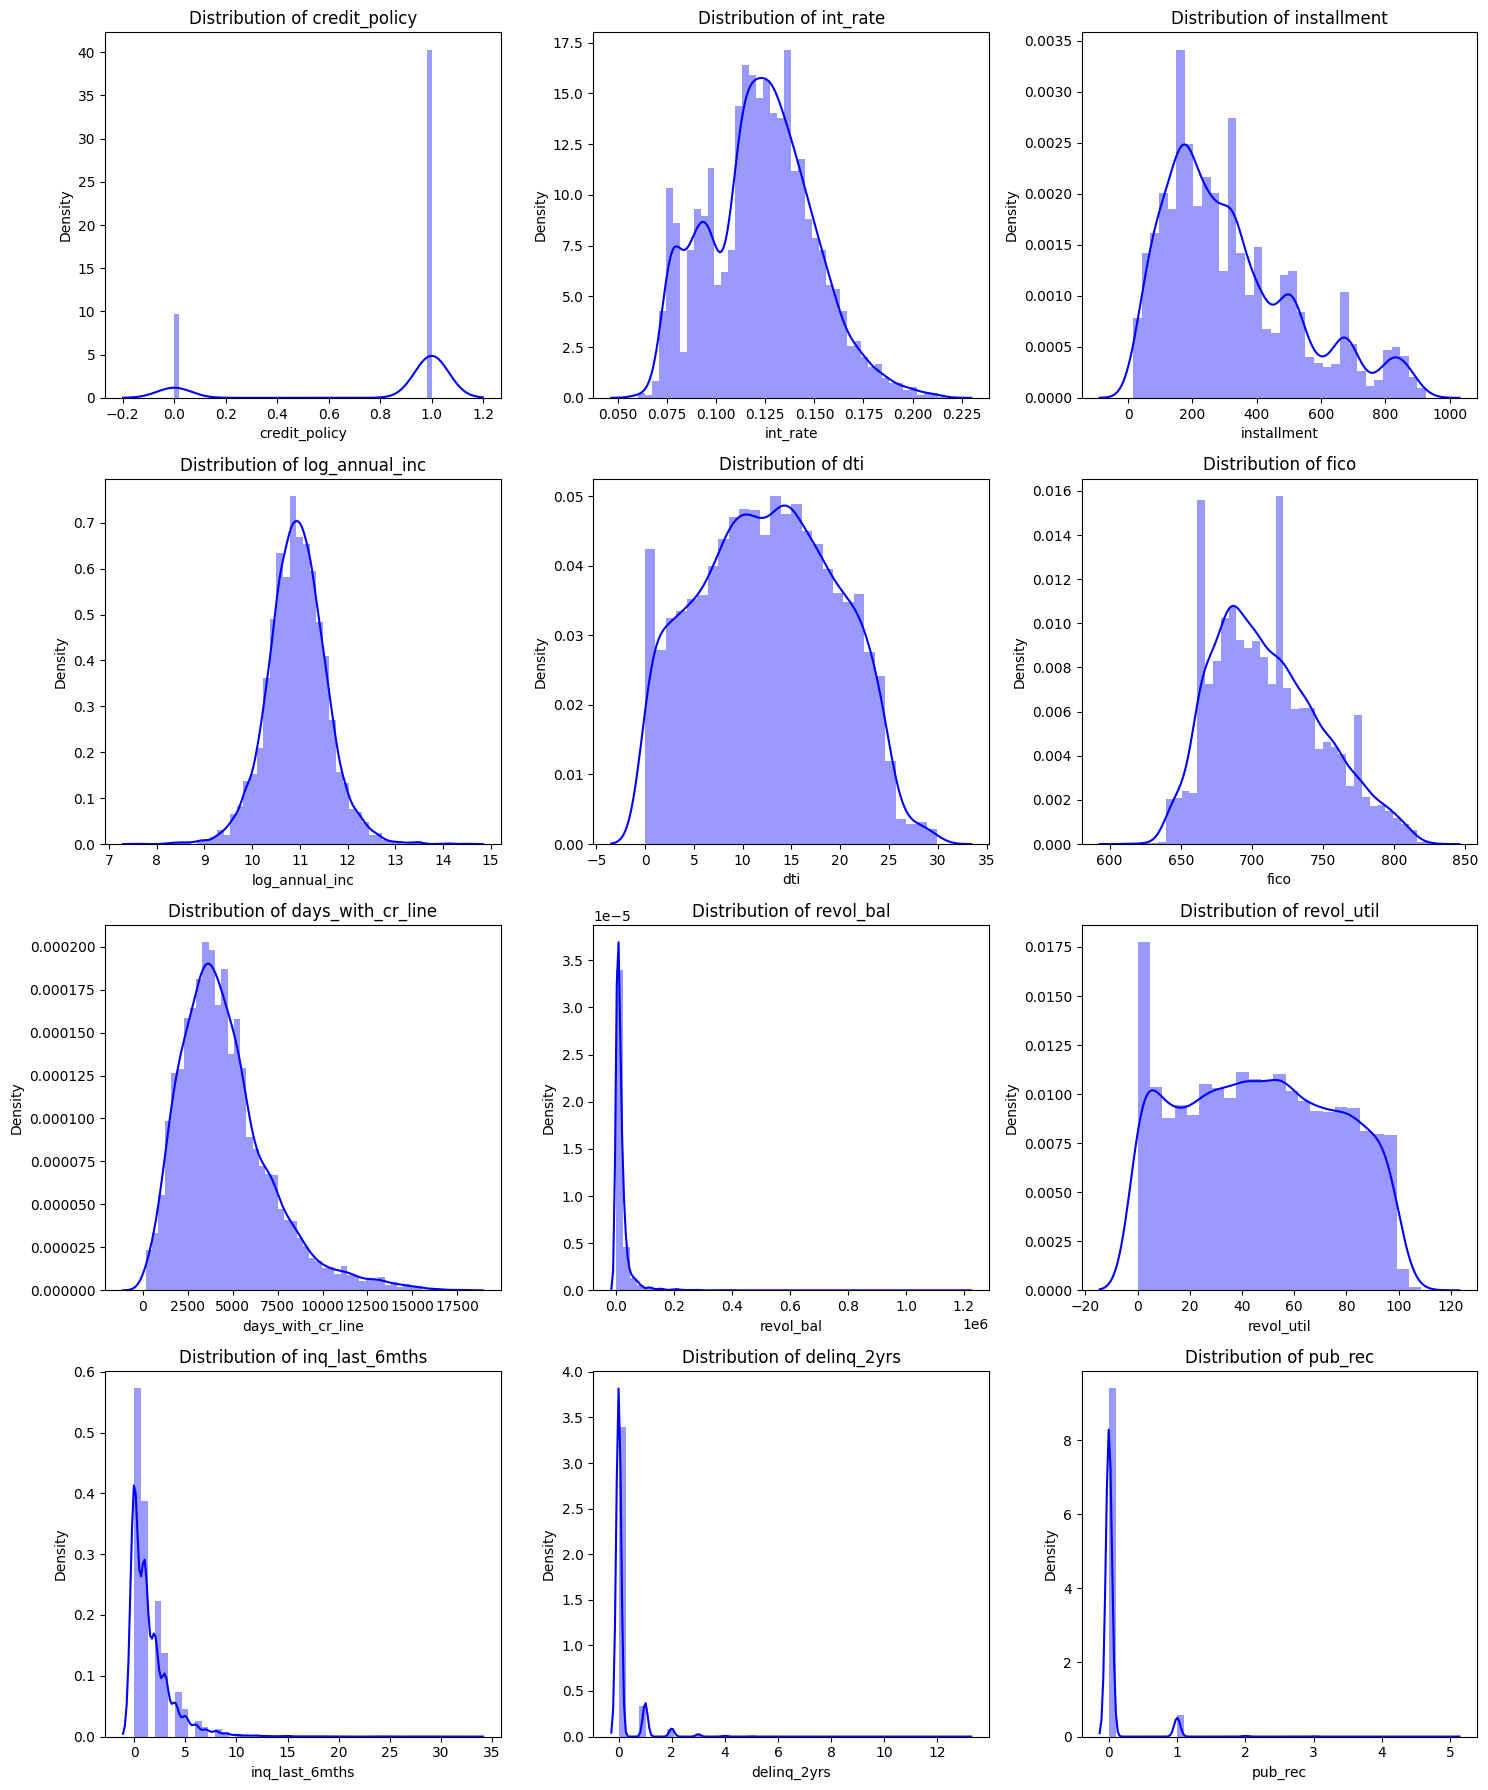

In [12]:
# Check distribution num
print(f'=== Distribution of features (before log transformation) ===')
plt.figure(figsize=(15, 18))
for i, col in enumerate(num):
    # Plot distribution 
    plt.subplot(4,3,i+1); sns.distplot(X_train[col], color='blue')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

From the above, we see that except for `log_annual_inc`, all the other numerical features are highly skewed.   
This can pose a problem when modelling as most machine learning models require features to be normally distributed.
Thus, we will perform log transformation before using these features in our modelling.   


In [13]:
# Log transform function
def log_transform(data, to_log):
    X = data.copy()
    for item in to_log:
        # Add 1 to the data to prevent infinity values
        X[item] = np.log(1+X[item])
    return X

In [81]:
# Display unique values in cat data
X_train['purpose'].unique()
# X_train.head()

array(['major_purchase', 'all_other', 'debt_consolidation', 'credit_card',
       'home_improvement', 'small_business', 'educational'], dtype=object)

In [84]:
# Transform categorial features to num 
X_train_e = pd.get_dummies(data=X_train)
print(X_train_e.head())

X_train_e = X_train_e.drop(['purpose_all_other'], axis=1)

X_test_e = pd.get_dummies(data=X_test)
X_test_e = X_test_e.drop(['purpose_all_other'], axis=1)

X_valid_e = pd.get_dummies(data=X_valid)
X_valid_e = X_valid_e.drop(['purpose_all_other'], axis=1)

# X_train_e.head()

      credit_policy  int_rate  installment  log_annual_inc    dti  fico  \
4247              1    0.0774       156.10       10.584056  10.27   797   
8766              0    0.1064        50.49       10.308953  15.60   697   
1509              1    0.1399       854.32       11.695247  19.76   692   
6120              1    0.1218       807.53       10.907386  17.41   737   
1069              1    0.1071       244.52       11.289682  13.02   702   

      days_with_cr_line  revol_bal  revol_util  inq_last_6mths  delinq_2yrs  \
4247        5490.000000       2629         8.8               2            0   
8766        6389.958333       1085        11.4              11            1   
1509        3780.041667      41077        60.0               0            1   
6120        4111.041667      28559        73.2               0            0   
1069        3479.958333       8709        30.1               3            0   

      pub_rec  purpose_all_other  purpose_credit_card  \
4247        0    

In [16]:
# Log transform
to_log = ['credit_policy', 'int_rate', 'installment', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
X_train_e_l = log_transform(X_train_e, to_log)
X_test_e_l = log_transform(X_test_e, to_log)
X_valid_e_l = log_transform(X_valid_e, to_log)
X_train_e_l.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
4247,0.693147,0.074551,5.056883,10.584056,2.422144,6.682109,8.610866,7.874739,2.282382,1.098612,0.000000,0.0,False,False,False,False,True,False
8766,0.000000,0.101112,3.941388,10.308953,2.809403,6.548219,8.762640,6.990257,2.517696,2.484907,0.693147,0.0,False,False,False,False,False,False
1509,0.693147,0.130941,6.751476,11.695247,3.033028,6.541030,8.237755,10.623228,4.110874,0.000000,0.693147,0.0,False,True,False,False,False,False
6120,0.693147,0.114935,6.695218,10.907386,2.912894,6.603944,8.321675,10.259762,4.306764,0.000000,0.000000,0.0,False,True,False,False,False,False
1069,0.693147,0.101744,5.503378,11.289682,2.640485,6.555357,8.155063,9.072227,3.437208,1.386294,0.000000,0.0,False,True,False,False,False,False


In [17]:
X_train_e_l.describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
count,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000
mean,0.558444,0.115248,5.538689,10.942256,2.408858,6.566778,8.270154,8.632424,3.503761,0.705485,0.097164,0.043538
std,0.274288,0.023849,0.729591,0.613794,0.724316,0.052720,0.607116,2.144157,1.097500,0.664321,0.282366,0.174050
min,0.000000,0.058269,2.814810,7.600902,0.000000,6.418365,5.198727,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.693147,0.098442,5.107883,10.571317,2.096790,6.526495,7.944847,8.065029,3.149524,0.000000,0.000000,0.000000
50%,0.693147,0.115202,5.598681,10.933107,2.608598,6.562444,8.328693,9.059169,3.856510,0.693147,0.000000,0.000000
75%,0.693147,0.130326,6.076154,11.314475,2.936911,6.603944,8.658874,9.824241,4.276666,1.098612,0.000000,0.000000
max,0.693147,0.195896,6.832849,14.528354,3.432696,6.719013,9.777979,14.003947,4.698661,3.526361,2.639057,1.791759


Now that log transformation is done, we check the distribution of the numerical features again.   
In general, the distributions have improved and are no longer as skewed as before.   
However, we noticed that each feature is on a different scale.   
e.g. `log_annual_inc` is on a much larger scale and might unnecessarily scale our models.   
Thus, we will proceed next to normalize the features before modelling.  


=== Distribution of features (after log transformation) ===


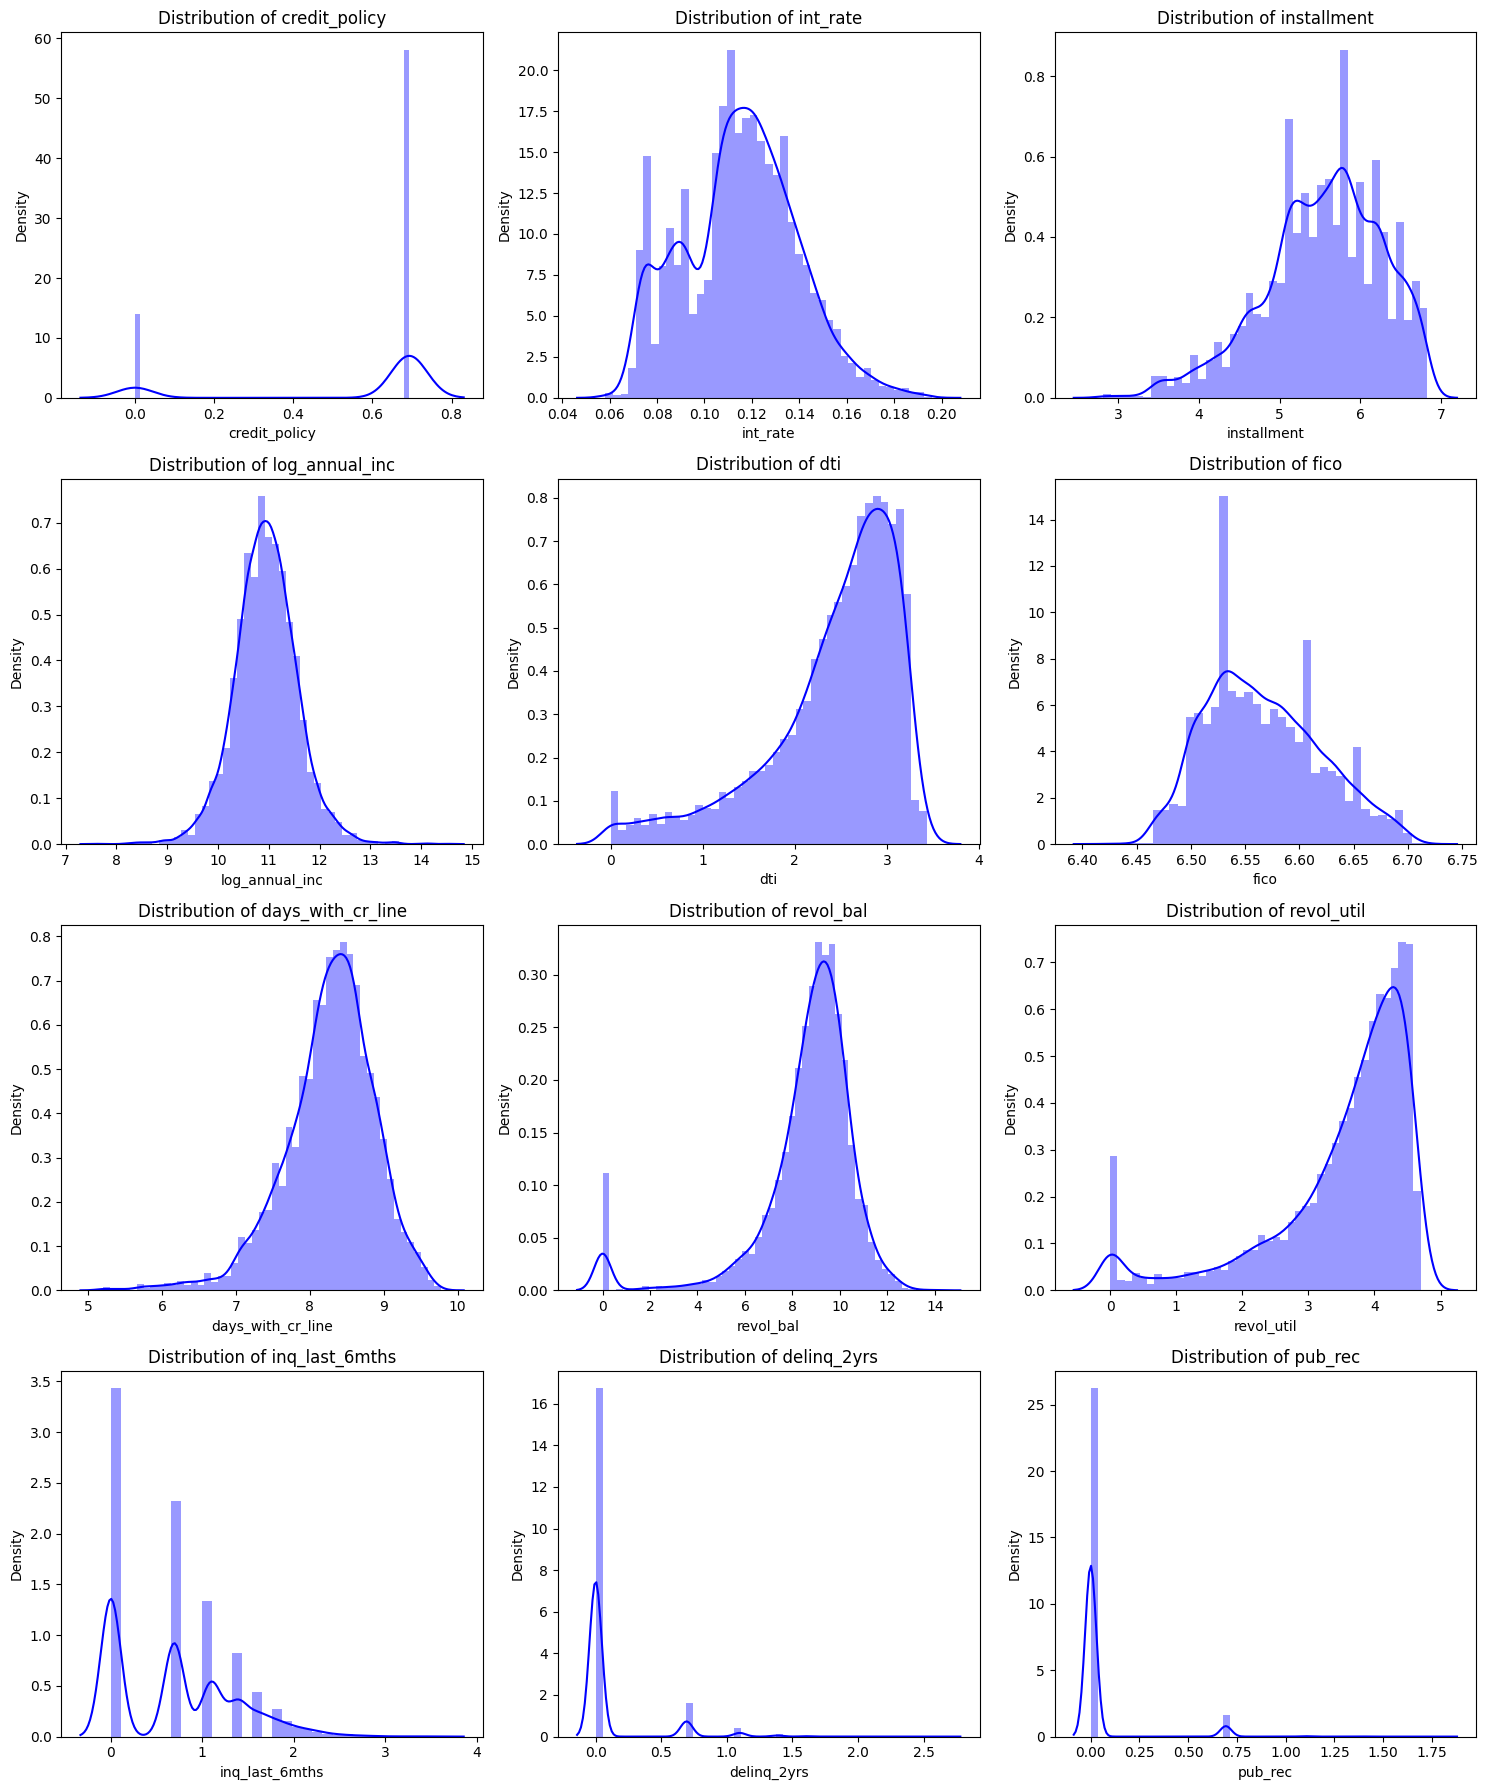

In [18]:
# Check distribution (num)
print(f'=== Distribution of features (after log transformation) ===')
plt.figure(figsize=(15, 18))
for i, col in enumerate(num):
    # Plot distribution 
    plt.subplot(4,3,i+1); sns.distplot(X_train_e_l[col], color='blue')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

In [19]:
# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(X_train_e_l)

# Scale and center the data
tmp_train = scaler.transform(X_train_e_l)
tmp_test = scaler.transform(X_test_e_l)
tmp_valid = scaler.transform(X_valid_e_l)

# Create a pandas DataFrame
X_train_e_l_n = pd.DataFrame(data=tmp_train, index=X_train_e.index, columns=X_train_e.columns)    
X_test_e_l_n = pd.DataFrame(data=tmp_test, index=X_test_e.index, columns=X_test_e.columns) 
X_valid_e_l_n = pd.DataFrame(data=tmp_valid, index=X_valid_e.index, columns=X_valid_e.columns) 

In [79]:
X_train_e_l_n.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
4247,0.491133,-1.706565,-0.660422,-0.583622,0.018345,2.187756,0.561234,-0.353395,-1.112946,0.591812,-0.344128,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,4.612294,-0.263656
8766,-2.036108,-0.592791,-2.189453,-1.031852,0.553034,-0.352051,0.811242,-0.765930,-0.898523,2.678732,2.110818,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,-0.216812,-0.263656
1509,0.491133,0.658032,1.662392,1.226862,0.861794,-0.488425,-0.053369,0.928539,0.553214,-1.062034,2.110818,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
6120,0.491133,-0.013149,1.585278,-0.056814,0.695924,0.705015,0.084867,0.759014,0.731713,-1.062034,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
1069,0.491133,-0.566269,-0.048401,0.566067,0.319808,-0.216652,-0.189583,0.205130,-0.060645,1.024887,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656


In [21]:
X_train_e_l_n.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
4247,0.491133,-1.706565,-0.660422,-0.583622,0.018345,2.187756,0.561234,-0.353395,-1.112946,0.591812,-0.344128,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,4.612294,-0.263656
8766,-2.036108,-0.592791,-2.189453,-1.031852,0.553034,-0.352051,0.811242,-0.765930,-0.898523,2.678732,2.110818,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,-0.216812,-0.263656
1509,0.491133,0.658032,1.662392,1.226862,0.861794,-0.488425,-0.053369,0.928539,0.553214,-1.062034,2.110818,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
6120,0.491133,-0.013149,1.585278,-0.056814,0.695924,0.705015,0.084867,0.759014,0.731713,-1.062034,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
1069,0.491133,-0.566269,-0.048401,0.566067,0.319808,-0.216652,-0.189583,0.205130,-0.060645,1.024887,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656


As expected, after scaling, all data now has mean 0, std deviation 1.    

### 3.2 Categorial features 

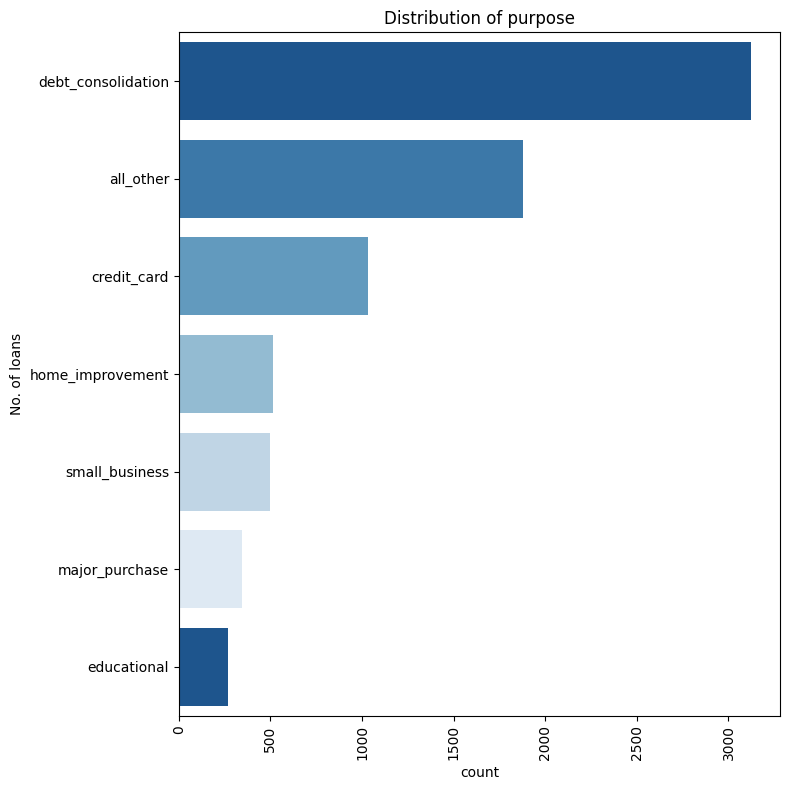

In [22]:
# Check distribution (non-num)
plt.figure(figsize=(8, 8))
# Plot distribution 
for i, col in enumerate(['purpose']):
    order = train[col].value_counts().index   
    plt.subplot(1,1,i+1); sns.countplot(train[col],palette=cmap, order = order ) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('No. of loans')
    plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

From the above, we see that the largest purpose for a loan is debt consolidation and other purposes.   
Education is the least reason for a loan in this dataset. We will keep this in view to see how it might impact our modelling later. 

In [23]:
X_train[['purpose']].describe()

,purpose
count,7662
unique,7
top,debt_consolidation
freq,3125


t-SNE technique is then applied on the numerical features for visualization purpose.   
The output 2D array was plotted and color-coded by the categorial features to scan for potential clusters.   

In [24]:
# Plot tsne scatter plot
def tsne_scatterplot(data, hue):
    # Color the points 
    sns.scatterplot(x="t_SNE_PC_1", y="t_SNE_PC_2", hue=hue, data=data, alpha=0.3)
    plt.title(hue)

In [25]:
# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate=50)

In [26]:
X_train_num_l_n = X_train_e_l_n[num]
X_train_num_l_n.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
4247,0.491133,-1.706565,-0.660422,-0.583622,0.018345,2.187756,0.561234,-0.353395,-1.112946,0.591812,-0.344128,-0.250163
8766,-2.036108,-0.592791,-2.189453,-1.031852,0.553034,-0.352051,0.811242,-0.765930,-0.898523,2.678732,2.110818,-0.250163
1509,0.491133,0.658032,1.662392,1.226862,0.861794,-0.488425,-0.053369,0.928539,0.553214,-1.062034,2.110818,-0.250163
6120,0.491133,-0.013149,1.585278,-0.056814,0.695924,0.705015,0.084867,0.759014,0.731713,-1.062034,-0.344128,-0.250163
1069,0.491133,-0.566269,-0.048401,0.566067,0.319808,-0.216652,-0.189583,0.205130,-0.060645,1.024887,-0.344128,-0.250163


In [27]:
# Fit and transform the 
tsne_features = m.fit_transform(X_train_num_l_n)
print(tsne_features.shape)

(7662, 2)


In [28]:
# Create df
df_tsne = y_train.copy()
df_tsne = pd.concat([X_train, y_train], axis=1)
df_tsne['t_SNE_PC_1'] = tsne_features[:,0]
df_tsne['t_SNE_PC_2'] = tsne_features[:,1]
df_tsne.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,t_SNE_PC_1,t_SNE_PC_2
4247,1,major_purchase,0.0774,156.10,10.584056,10.27,797,5490.000000,2629,8.8,2,0,0,0,17.469032,13.708076
8766,0,all_other,0.1064,50.49,10.308953,15.60,697,6389.958333,1085,11.4,11,1,0,0,-32.440319,34.368259
1509,1,debt_consolidation,0.1399,854.32,11.695247,19.76,692,3780.041667,41077,60.0,0,1,0,0,-45.281734,11.338953
6120,1,debt_consolidation,0.1218,807.53,10.907386,17.41,737,4111.041667,28559,73.2,0,0,0,1,-19.195774,-28.433834
1069,1,debt_consolidation,0.1071,244.52,11.289682,13.02,702,3479.958333,8709,30.1,3,0,0,0,34.596832,-7.804299


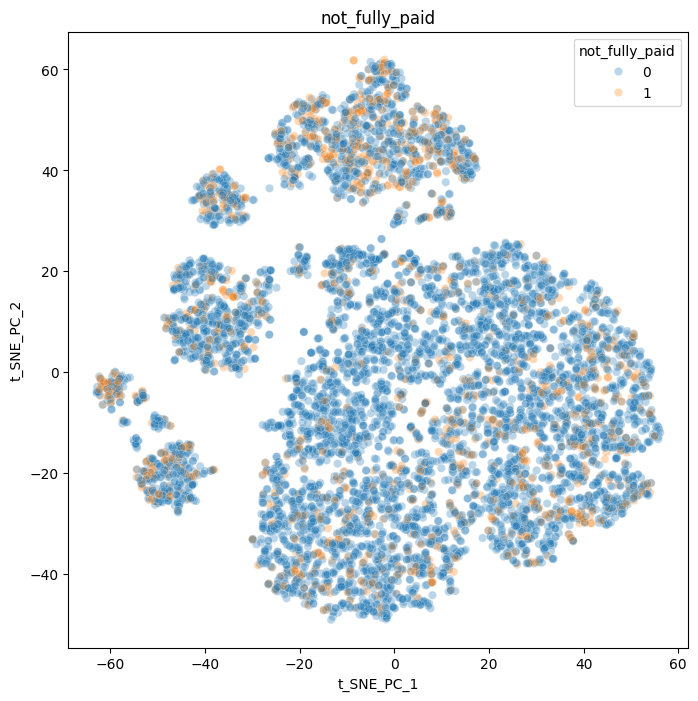

In [29]:
# Viz of y
plt.figure(figsize=(8,8))

# y 
tsne_scatterplot(df_tsne, 'not_fully_paid')
# Plot
plt.show()

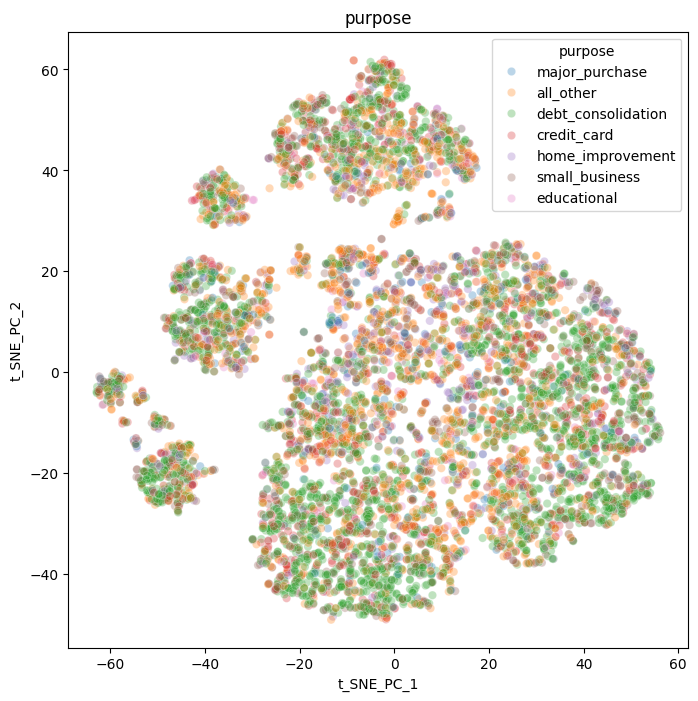

In [30]:
# Viz of purpose
plt.figure(figsize=(8,8))

# y 
tsne_scatterplot(df_tsne, 'purpose')
# Plot
plt.show()

Regretfully, we do not see distinct clusters for the loans which are fully paid vs those which are not.   
Additionally, there is no distinct clusters seen for purpose of the loan too.  


### 3.3. Target variable  

In this section, we analyze the distribution target feature in detail and examine if there's any point for concern before moving on to modelling.  


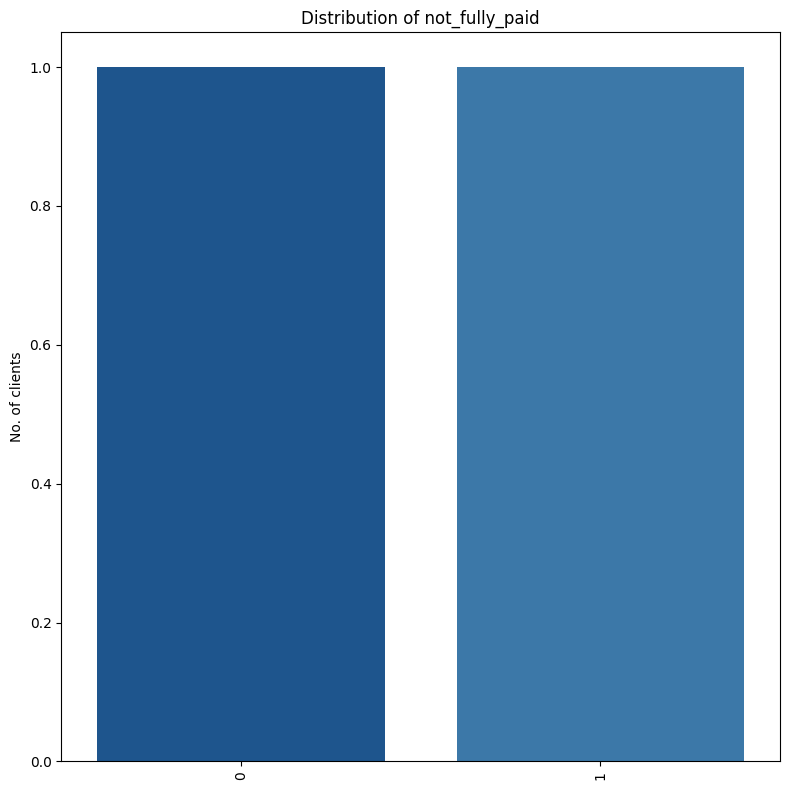

In [31]:
# Check distribution (non-num)
plt.figure(figsize=(8, 8))
# Plot distribution 
for i, col in enumerate(['not_fully_paid']):
    order = train[col].value_counts().index   
    plt.subplot(1,1,i+1); sns.countplot(train[col],palette=cmap, order = order ) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('No. of clients')
    plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

From the above, we see huge class imbalance in the target variable. i.e., Only approximately 15% of the loans are not fully paid.    
Thus, we must take care of this in the modelling (e.g., apply re-sampling technique) and ensure that huge class imbalance do not negatively impact our modelling performance.   

At this juncture, we argue that recall is the most important performance metric for our modelling purpose.  
This is because if a loan is not fully paid, the lender will incur high default risk. Thus, it is more important to have a good recall (low FN) instead of a high precision (low FP). In cases of FN, the lender will lose huge amount of monies due to default and this is highly undesirable. On the other hand, in cases of FP, the lender loses only potential revenue (at the expense of lower default risk) which we believe is comparatively acceptable.  


In [32]:
def stack_bar(d, xlabel, hue = 'lead_type'):
    plt.figure(figsize=(5, 5))
    train_pct = (d.groupby([xlabel,hue])['credit_policy'].count()/d.groupby([xlabel])['credit_policy'].count())
    train_pct.unstack().plot.bar(stacked=True)
    plt.ylabel('%') 
    plt.title(f'100% stack bar chart \n By {xlabel}')
    plt.show()   

<Figure size 500x500 with 0 Axes>

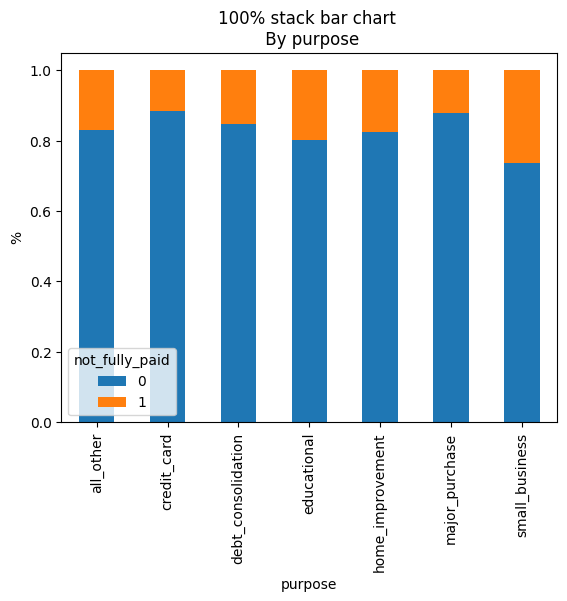

In [33]:
stack_bar(train, 'purpose', 'not_fully_paid')

From the chart above, small business and educational loan has the highest proportion of `not fully paid` loans.  
This is likely the case since such small businesses are more susceptible to volatile market and environment situations, resulting in higher chance of defaults.


In [34]:
# Convert target var to a categorial var
train['y'] = np.where(train['not_fully_paid']==1, 'yes', 'no')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7662 entries, 4247 to 2732
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      7662 non-null   int64  
 1   purpose            7662 non-null   object 
 2   int_rate           7662 non-null   float64
 3   installment        7662 non-null   float64
 4   log_annual_inc     7662 non-null   float64
 5   dti                7662 non-null   float64
 6   fico               7662 non-null   int64  
 7   days_with_cr_line  7662 non-null   float64
 8   revol_bal          7662 non-null   int64  
 9   revol_util         7662 non-null   float64
 10  inq_last_6mths     7662 non-null   int64  
 11  delinq_2yrs        7662 non-null   int64  
 12  pub_rec            7662 non-null   int64  
 13  not_fully_paid     7662 non-null   int64  
 14  y                  7662 non-null   object 
dtypes: float64(6), int64(7), object(2)
memory usage: 957.8+ KB


In [35]:
# Not fully paid 
train[train['y']=='yes'].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1.232000e+03,1232.000000,1232.000000,1232.000000,1232.000000,1232.0
mean,0.657468,0.132217,339.906583,10.888878,13.142516,697.957792,4455.193283,2.114125e+04,52.642638,2.370942,0.173701,0.092532,1.0
std,0.474749,0.025369,222.561810,0.663654,7.056859,33.611120,2495.372138,5.197035e+04,29.199771,2.986495,0.521533,0.292683,0.0
min,0.000000,0.070500,15.910000,7.600902,0.000000,627.000000,180.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.115250,167.952500,10.491274,7.670000,672.000000,2819.729167,3.315750e+03,30.550000,0.000000,0.000000,0.000000,1.0
50%,1.000000,0.131600,285.500000,10.896739,13.160000,692.000000,4079.979167,8.772000e+03,54.500000,1.000000,0.000000,0.000000,1.0
75%,1.000000,0.147400,486.182500,11.289782,18.822500,717.000000,5642.010417,2.029175e+04,77.725000,3.000000,0.000000,0.000000,1.0
max,1.000000,0.216400,926.830000,13.458836,29.960000,822.000000,15692.000000,1.207359e+06,106.500000,33.000000,4.000000,2.000000,1.0


In [36]:
# fully paid 
train[train['y']=='no'].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.0
mean,0.834059,0.120604,315.973201,10.952483,12.415751,713.582426,4613.677132,16456.155521,45.672799,1.431415,0.161742,0.059565,0.0
std,0.372057,0.026673,203.877046,0.603287,6.851301,38.175805,2544.263439,30658.033085,28.854027,1.976186,0.557167,0.265208,0.0
min,0.000000,0.060000,15.690000,8.294050,0.000000,612.000000,180.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.098800,163.762500,10.596535,7.032500,682.000000,2820.000000,3162.500000,21.100000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.121800,267.645000,10.950807,12.430000,707.000000,4169.500000,8543.500000,44.750000,1.000000,0.000000,0.000000,0.0
75%,1.000000,0.138500,425.910000,11.320554,17.700000,742.000000,5790.000000,18149.500000,69.400000,2.000000,0.000000,0.000000,0.0
max,1.000000,0.212100,926.830000,14.528354,29.950000,827.000000,17639.958330,952013.000000,108.800000,28.000000,13.000000,5.000000,0.0


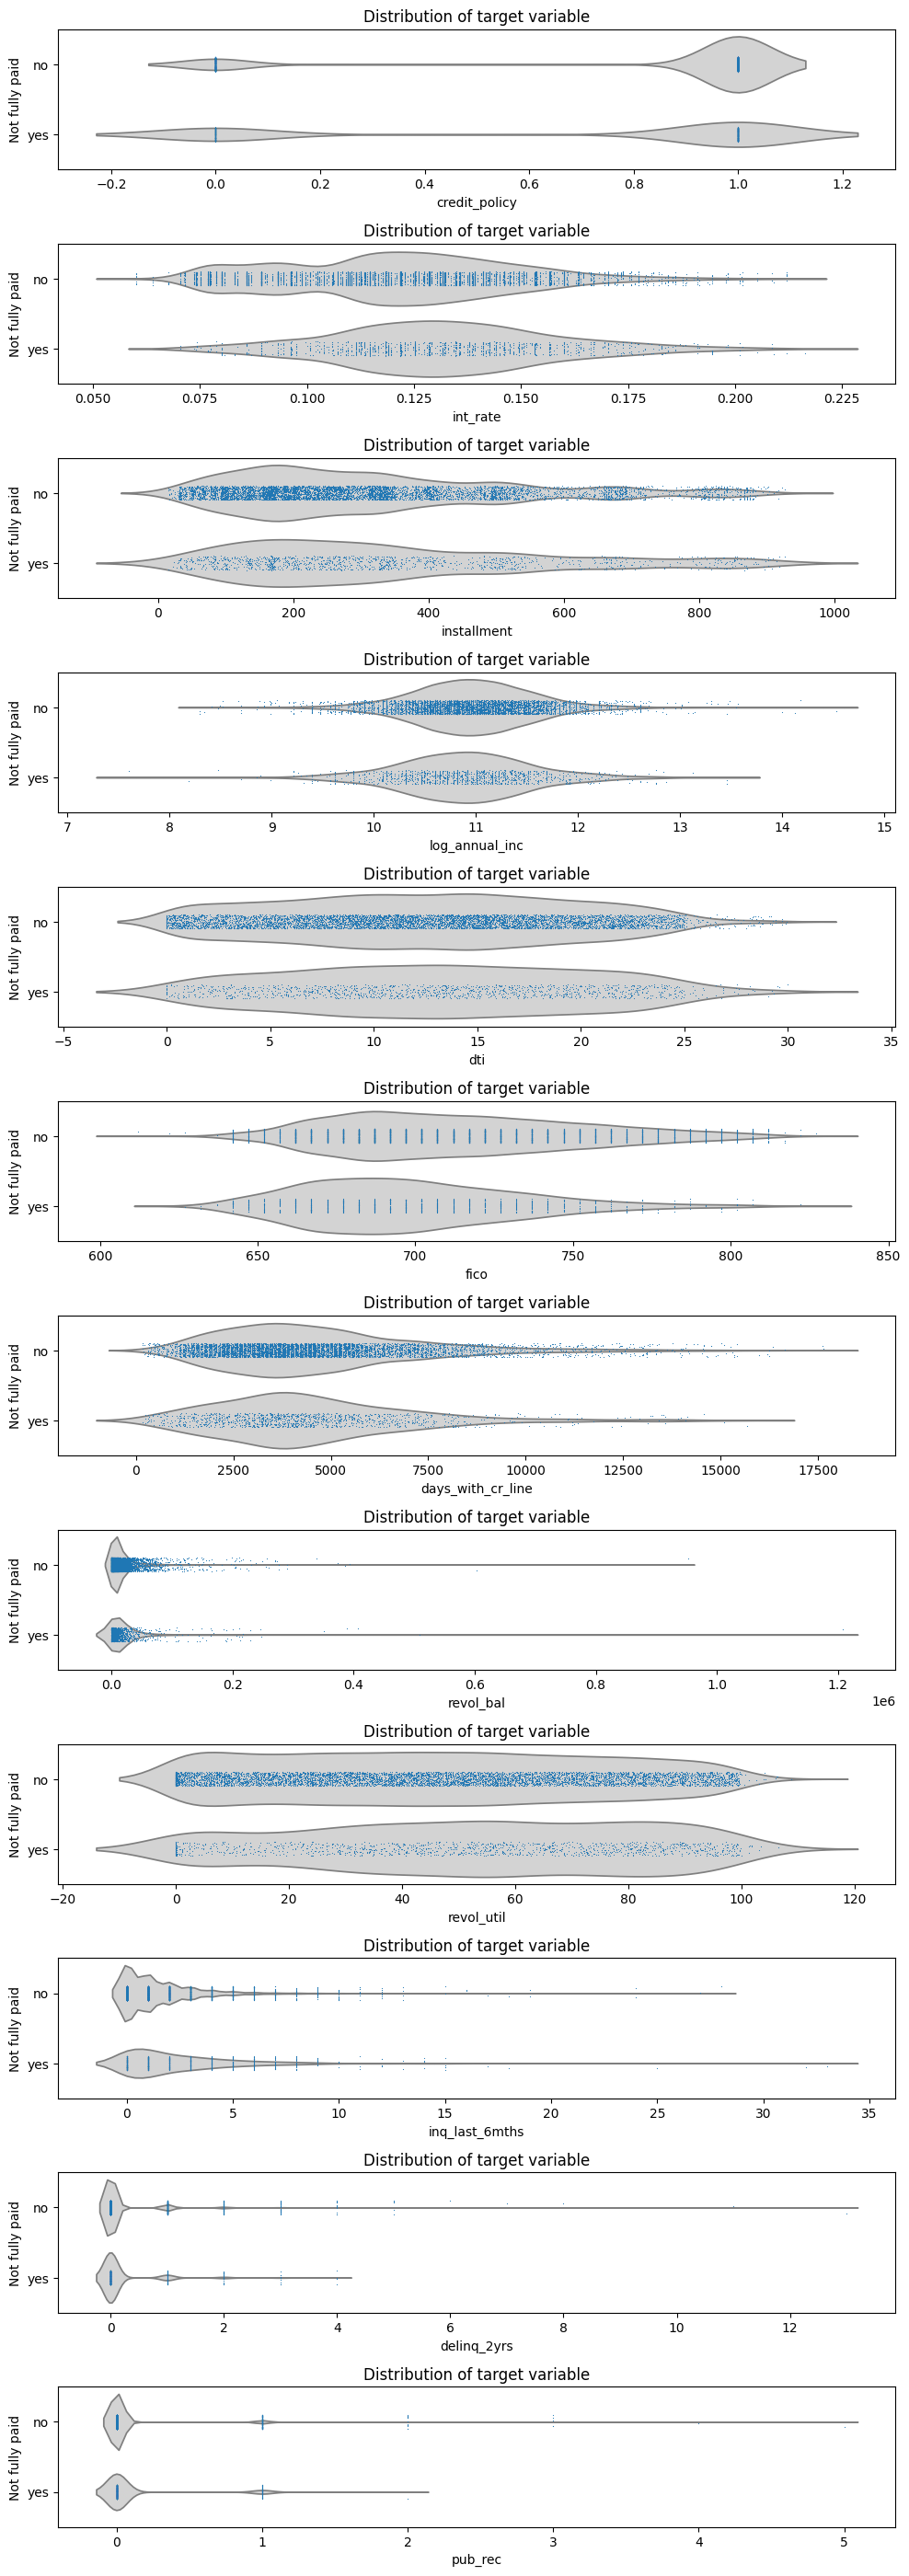

In [37]:
# Check distribution (num)
plt.figure(figsize=(10, 30))
# Plot distribution 
for i, col in enumerate(num):
    plt.subplot(13,1,1+i); sns.violinplot(x=col, y='y', data=train, inner=None, color='lightgray');sns.stripplot(x=col, y='y', data=train, size=0.8,jitter=True);
    plt.title('Distribution of target variable');
    plt.ylabel('Not fully paid')
    # Show the plot
plt.tight_layout()
plt.show()

From the plots above, loans not fully paid generally have higher interest rate, larger number of inquiries by creditors in the last 6 months, lower revolving balance, lower credit policy and lower FICO.  

We will review these observations in the feature selection section to determine which features are important for our modelling purpose.  


### 4. Feature selection   

In this section, we first determine the number of features required for modelling purpose using PCA analysis.      
Next, we will use Recursive feature elimination (RFE) to determine the features to use for modelling.   
RFE is a greedy algorithm which recursively remove features and build new models on the remaining features. Based on the model(s) accuracy, it then identifies relevant features which contributed most to predicting the target variable. (Data camp, 2020)



### 4.1 Number of features to use - PCA analysis 
With PCA, we first gain an intuition on the number of features required to explain the variance in all candidate features. PCA was chosen because it can perform dimensionality reduction and remove multi-collinearity at the same time. Up-sampling is done to overcome issues with the imbalance dataset before performing PCA.    


In [38]:
def upsample_data(X, y):
    # Concat
    data = pd.concat([X, y], axis=1)
    #data.head()
    subscribe = data[data['not_fully_paid']==1]
    not_subscribe = data[data['not_fully_paid']==0]
    # Upsample minority and combine with majority
    data_upsampled = resample(not_subscribe, replace=True, n_samples=len(subscribe), random_state=0)
    upsampled = pd.concat([subscribe, data_upsampled])
    # Upsampled feature matrix and target array
    X_up = upsampled.drop('not_fully_paid', axis=1)
    y_up = upsampled[['not_fully_paid']]
    #X_up.head()
    
    return X_up, y_up

In [39]:
# Perform upsample on all dataset
X_train_e_l_n_up, y_train_up = upsample_data(X_train_e_l_n, y_train)
X_test_e_l_n_up, y_test_up = upsample_data(X_test_e_l_n, y_test)
X_valid_e_l_n_up, y_valid_up = upsample_data(X_valid_e_l_n, y_valid)

In [40]:
X_train_e_l_n_up.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2464 entries, 6120 to 9561
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               2464 non-null   float64
 1   int_rate                    2464 non-null   float64
 2   installment                 2464 non-null   float64
 3   log_annual_inc              2464 non-null   float64
 4   dti                         2464 non-null   float64
 5   fico                        2464 non-null   float64
 6   days_with_cr_line           2464 non-null   float64
 7   revol_bal                   2464 non-null   float64
 8   revol_util                  2464 non-null   float64
 9   inq_last_6mths              2464 non-null   float64
 10  delinq_2yrs                 2464 non-null   float64
 11  pub_rec                     2464 non-null   float64
 12  purpose_credit_card         2464 non-null   float64
 13  purpose_debt_consolidation  2464 no

In [41]:
# Set attributes for PCA analysis
n=18
columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18']

In [42]:
# Create the PCA instance and fit and transform the data with pca
pca = PCA(n_components=n)
pc = pca.fit_transform(X_train_e_l_n)
df_pc = pd.DataFrame(pc, columns=columns, index=X_train_e_l_n.index)
df_pc.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18
4247,3.256996,-0.246222,-0.206230,0.563453,0.279455,0.575534,3.580817,1.013099,2.437941,0.812285,-0.261670,-0.619781,-0.758068,-0.155953,-0.208116,-0.330471,-0.211646,0.289211
8766,0.244595,2.712633,1.299334,0.651076,1.424221,1.194629,0.524848,0.388815,0.646855,-2.001559,-2.720793,0.043031,0.106035,-0.248603,0.096794,0.496380,-0.080832,-0.153684
1509,-1.932073,-1.556520,-0.110169,-1.357010,-1.221481,1.289136,-0.235875,-1.096475,0.340110,-0.667406,0.256430,-0.086030,-0.649434,0.867972,0.583748,0.003313,-0.041487,0.031403
6120,-0.790266,-1.769093,-1.204595,-1.056188,-0.180938,-0.473822,0.014383,-0.280887,0.036320,-0.028006,0.464979,-0.451753,-0.582352,0.471907,-0.493793,0.173686,0.091046,0.275072
1069,-0.336338,-0.318002,-0.410661,-0.823692,0.829951,-0.399236,0.340919,0.091516,0.033393,-0.549392,-0.076001,0.128169,-0.105765,-0.588484,1.070894,-0.414630,0.122366,-0.359232


In [43]:
pca.explained_variance_ratio_

array([0.15887756, 0.125795  , 0.09042296, 0.07512441, 0.06369233,
       0.06116488, 0.05774666, 0.05561229, 0.05417588, 0.05351061,
       0.04836214, 0.03955678, 0.02852432, 0.02711373, 0.02414615,
       0.01615035, 0.0113211 , 0.00870286])

In [44]:
# PCA df which store PCA componenets and corresponding y
df_PCA = pd.concat([df_pc, y_train], axis=1)
df_PCA.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,not_fully_paid
4247,3.256996,-0.246222,-0.206230,0.563453,0.279455,0.575534,3.580817,1.013099,2.437941,0.812285,-0.261670,-0.619781,-0.758068,-0.155953,-0.208116,-0.330471,-0.211646,0.289211,0
8766,0.244595,2.712633,1.299334,0.651076,1.424221,1.194629,0.524848,0.388815,0.646855,-2.001559,-2.720793,0.043031,0.106035,-0.248603,0.096794,0.496380,-0.080832,-0.153684,0
1509,-1.932073,-1.556520,-0.110169,-1.357010,-1.221481,1.289136,-0.235875,-1.096475,0.340110,-0.667406,0.256430,-0.086030,-0.649434,0.867972,0.583748,0.003313,-0.041487,0.031403,0
6120,-0.790266,-1.769093,-1.204595,-1.056188,-0.180938,-0.473822,0.014383,-0.280887,0.036320,-0.028006,0.464979,-0.451753,-0.582352,0.471907,-0.493793,0.173686,0.091046,0.275072,1
1069,-0.336338,-0.318002,-0.410661,-0.823692,0.829951,-0.399236,0.340919,0.091516,0.033393,-0.549392,-0.076001,0.128169,-0.105765,-0.588484,1.070894,-0.414630,0.122366,-0.359232,0


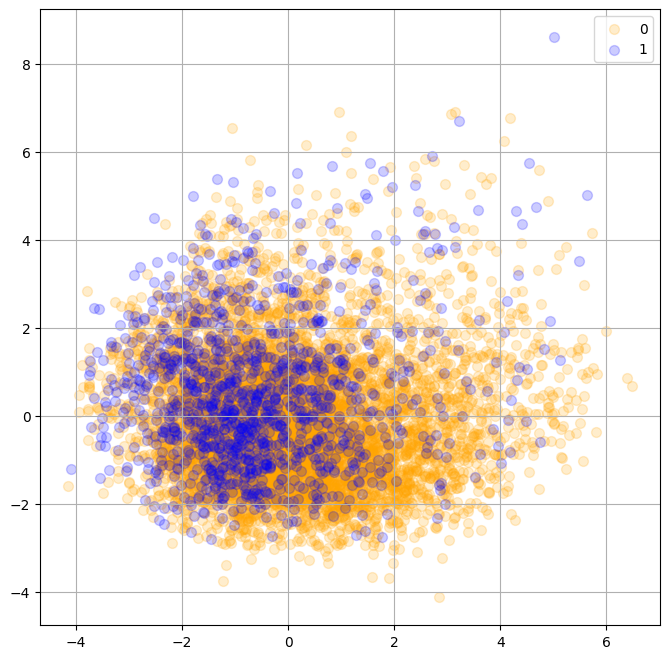

In [45]:
targets = [0, 1]
colors = ['orange', 'blue']

fig, ax = plt.subplots(figsize=(8,8))


# For loop to create plot
for target, color in zip(targets,colors):
    indicesToKeep = df_PCA['not_fully_paid'] == target
    ax.scatter(df_PCA.loc[indicesToKeep, 'PCA_1']
               , df_PCA.loc[indicesToKeep, 'PCA_2']
               , c = color
               , s = 50
              , alpha =0.2)

# Legend    
ax.legend(targets)
ax.grid()
plt.show()

From the PCA plot, we can see distinct clusters between loans fully paid (orange) vs loans which are not (blue).      
We will study next the number of features required to explain the variance in the dataset to gain an intuition of the number of features required for our modelling purpose.  

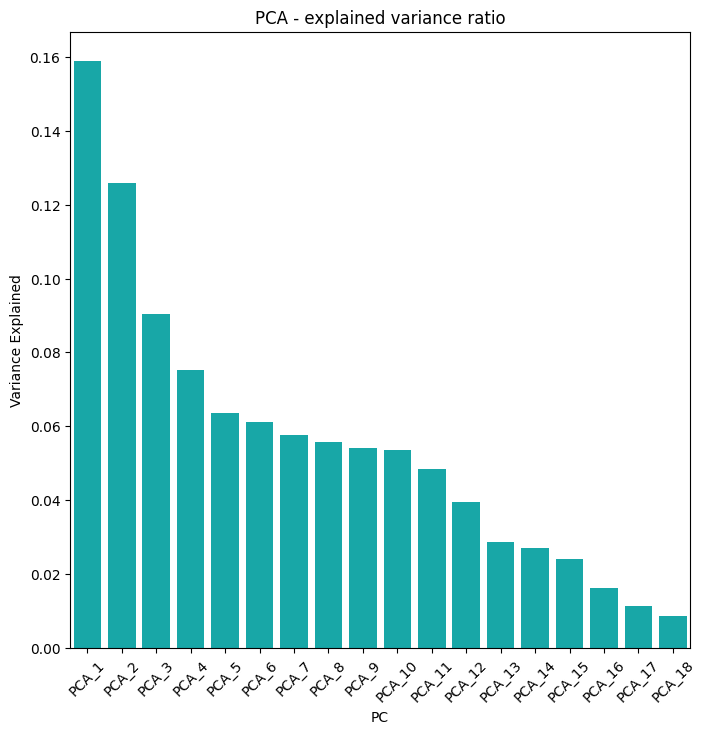

In [46]:
# Instantiate
pca = PCA(n_components=n)

# Fit and transform
principalComponents = pca.fit_transform(X_train_e_l_n)

# List principal components names
principal_components =columns

# Create a DataFrame
pca_df = pd.DataFrame({'Variance Explained': pca.explained_variance_ratio_,
             'PC':principal_components})

plt.figure(figsize=(8, 8))
plt.title('PCA - explained variance ratio')
# Plot DataFrame
sns.barplot(x='PC',y='Variance Explained', 
           data=pca_df, color="c")
plt.xticks(rotation=45)
plt.show()

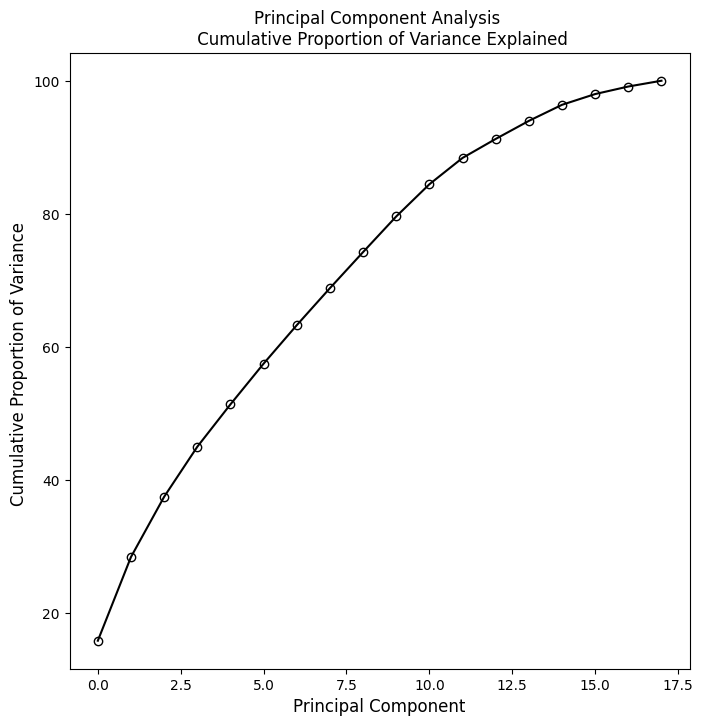

In [47]:
plt.figure(figsize=(8, 8))
# Instantiate, fit and transform
#pca2 = PCA()
#principalComponents2 = pca2.fit_transform(X_train_valid_e_n_up)

# Assign variance explained
var = pca.explained_variance_ratio_

# Plot cumulative variance
cumulative_var = np.cumsum(var)*100
plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ",fontsize=12)
plt.show()

From the plots above, we see that approximately 12 features are needed to explain 90% of the variance in the dataset.    
This gives us a good intuition of the number of features required in our model.   

Next, We will next use RFE to which are the important features for modelling.   

### 4.2 Feature importance - Recursive feature elimination   

To better understand the features to use in our model, we will rank all features according to feature importance.     
Thereafter, we select the final features via RFE using steps below. 
1.	Use Recursive feature elimination(RFE)  with Logistic regression as the model to select the most important features 
2.	Repeat step 1 but use Random Forest and Gradient boosting as the models instead
3.	Finally, select only features which has been voted by at least 2 models as important features


In [48]:
# Function to find lowest C and plot the result
def lowest_err(model, C_values, train_errs, valid_errs):
    
    # Print lowest valid err
    C_values_df = pd.DataFrame(C_values)
    valid_errs_df = pd.DataFrame(valid_errs)
    min_err = min(valid_errs_df[0])
    min_idx = valid_errs_df[0].idxmin(axis = 0)
    min_C = C_values_df.loc[min_idx, 0]
    print(f'Min validation error ({model})  occur at C={round(min_C, 5)} and error = {round(min_err,5)}')

    # Plot results
    plt.figure(figsize=(8,5))
    plt.semilogx(C_values, train_errs, C_values, valid_errs)
    plt.annotate(f'Min error occur at Hyper-param ={round(min_C, 5)} and error = {round(min_err,5)}', xy=(min_C, min_err),fontsize=12,arrowprops=dict(facecolor='red', shrink=0.5),)
    plt.legend(("train", "validation"))
    plt.title(model)
    plt.xlabel('Hyper-parameter')
    plt.ylabel('Error')
    plt.show()
    
    # Return
    return {'Model':model, 'Best hyperparam': min_C}

Before performing RFE, we first quickly select the best hyper-params to use for logistic regression, random forest, and gradient boosting.

### a. Logistic regression

In [49]:
min_C = list()

In [50]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()
C_values = np.logspace(-6, -2, 21)

# Loop over values of C_value
for C_value in C_values:
    # Create LogisticRegression object and fit
    clf = LogisticRegression(C=C_value)
    clf.fit(X_train_e_l_n_up, y_train_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(X_train_e_l_n_up, y_train_up) )
    valid_errs.append( 1.0 - clf.score(X_valid_e_l_n_up, y_valid_up) )

Min validation error (Logistic regression)  occur at C=1e-05 and error = 0.37375


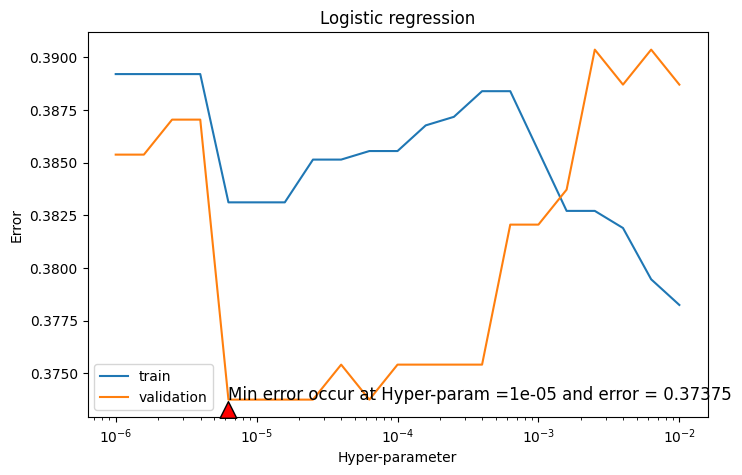

In [51]:
# Plot and find min C
min_C.append( lowest_err('Logistic regression', C_values, train_errs, valid_errs) )

### b. Gradient boosting

In [52]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()
C_values = [int(x) for x in np.linspace(1, 900, 21)]

# Loop over values of C_value
for C_value in C_values:
    # Create LogisticRegression object and fit
    clf = GradientBoostingClassifier(n_estimators=C_value)
    clf.fit(X_train_e_l_n_up, y_train_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(X_train_e_l_n_up, y_train_up) )
    valid_errs.append( 1.0 - clf.score(X_valid_e_l_n_up, y_valid_up) )

Min validation error (Gradient boosting)  occur at C=45 and error = 0.38372


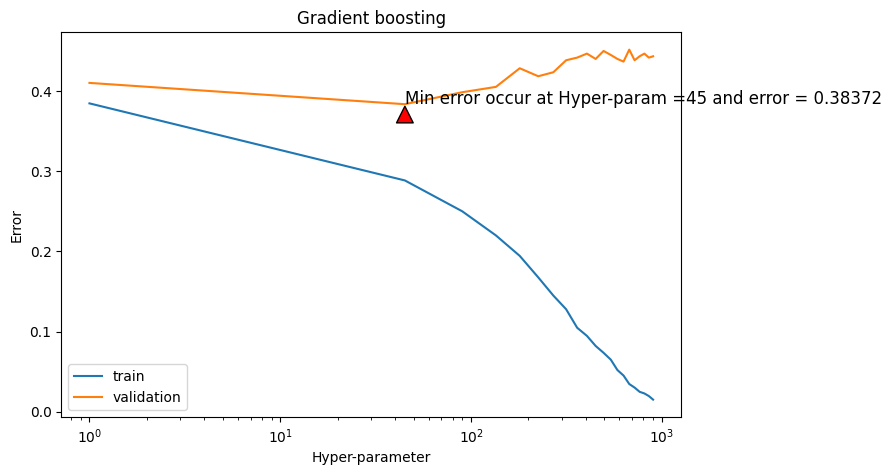

In [53]:
# Plot and find min C
min_C.append( lowest_err('Gradient boosting', C_values, train_errs, valid_errs) )

### c. Random forest

In [54]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()
C_values = [int(x) for x in np.linspace(1, 900, 21)]

# Loop over values of C_value
for C_value in C_values:
    # Create LogisticRegression object and fit
    clf = RandomForestClassifier(n_estimators=C_value,random_state=0)
    clf.fit(X_train_e_l_n_up, y_train_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(X_train_e_l_n_up, y_train_up) )
    valid_errs.append( 1.0 - clf.score(X_valid_e_l_n_up, y_valid_up) )

Min validation error (Random Forest)  occur at C=630 and error = 0.3588


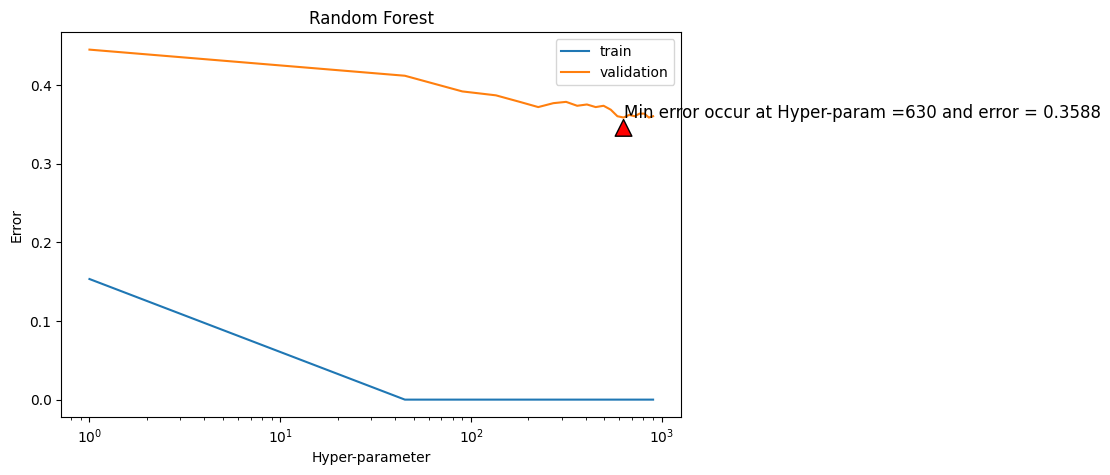

In [55]:
# Plot and find min C
min_C.append( lowest_err('Random Forest', C_values, train_errs, valid_errs) )

In [56]:
# Print min C
min_C = pd.DataFrame(min_C)
min_C.set_index('Model', inplace=True)
min_C

,Best hyperparam
Model,
Logistic regression,0.000006
Gradient boosting,45.000000
Random Forest,630.000000


Based on the above best hyper-params, we then run RFE to select the 12 most relevant features for each model. 

In [57]:
# Refit model with both train and valid data
X_train_valid_e_l_n_up = pd.concat([X_train_e_l_n_up, X_valid_e_l_n_up], axis=0)
X_train_valid_e_l_n_up.tail()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
7689,0.491133,-0.740864,-0.362008,-0.199555,0.920389,-0.082211,-1.168804,0.590105,0.411253,0.591812,-0.344128,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,-0.216812,-0.263656
1468,0.491133,-0.759885,-1.218471,-0.926699,-0.863583,0.183844,1.476485,-0.806279,-2.132814,-0.018574,3.546869,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,-0.216812,-0.263656
4265,0.491133,-1.706565,-0.201707,-0.283128,0.725602,1.086707,0.329707,0.111511,0.057362,-0.018574,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
7582,0.491133,0.878172,1.368579,-0.646700,0.584284,-0.764148,-0.822087,-0.632073,-0.755961,-0.018574,2.110818,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
4256,0.491133,-1.706565,0.285276,-0.266067,-1.644391,2.187756,0.534011,-0.087493,-0.719014,-1.062034,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656


In [58]:
y_train_valid_e_l_n_up = pd.concat([y_train_up,y_valid_up], axis=0)
y_train_valid_e_l_n_up.tail()

,not_fully_paid
7689,0
1468,0
4265,0
7582,0
4256,0


In [59]:
# Set RFE params
n_features_to_select = 12
step = 1

In [60]:
# RFE with Logistic regression
rfe_lg = RFE(estimator=LogisticRegression(C=min_C.loc['Logistic regression', 'Best hyperparam']), 
             n_features_to_select=n_features_to_select, step=step, verbose=1)
rfe_lg.fit(X_train_valid_e_l_n_up, y_train_valid_e_l_n_up)
# Calculate the score on the test set
#score = rfe_lg.score(X_test_e_l_n, y_test)
score = rfe_lg.score(X_test_e_l_n_up, y_test_up)
print('Logistic regression can explain {0:.1%} of the variance in the test set'.format(score))
# Assign the support array to mask
lg_mask = rfe_lg.support_

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Logistic regression can explain 63.1% of the variance in the test set


In [61]:
# RFE with Gradient boosting 

# Select 10 features with RFE on a GradientBoostingClassifier, drop 1 features on each step
rfe_gb = RFE(estimator=GradientBoostingClassifier(n_estimators=int(min_C.loc['Gradient boosting', 'Best hyperparam']), random_state=0), 
             n_features_to_select=n_features_to_select, step=step, verbose=1)
rfe_gb.fit(X_train_valid_e_l_n_up, y_train_valid_e_l_n_up)
# Calculate the score on the test set
#score = rfe_gb.score(X_test_e_l_n, y_test)
score = rfe_gb.score(X_test_e_l_n_up, y_test_up)
print('Gradient boosting can explain {0:.1%} of the variance in the test set'.format(score))
# Assign the support array to mask
gb_mask = rfe_gb.support_

Fitting estimator with 18 features.
Fitting estimator with 17 features.


Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Gradient boosting can explain 68.8% of the variance in the test set


In [62]:
# RFE with RandomForestClassifier
rfe_rf = RFE(estimator=RandomForestClassifier(n_estimators=int(min_C.loc['Random Forest', 'Best hyperparam']), random_state=0), 
             n_features_to_select=n_features_to_select, step=step, verbose=1)
rfe_rf.fit(X_train_valid_e_l_n_up, y_train_valid_e_l_n_up)
# Calculate the score on the test set
#score = rfe_rf.score(X_test_e_l_n_up, y_test_up)
#score = rfe_rf.score(X_test_e_l_n, y_test)
score = rfe_rf.score(X_test_e_l_n_up, y_test_up)
print('Random Forest can explain {0:.1%} of the variance in the test set'.format(score))
# Assign the support array to mask
rf_mask = rfe_rf.support_

Fitting estimator with 18 features.


Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Random Forest can explain 100.0% of the variance in the test set


In [63]:
# Sum the votes of the three models
votes = np.sum([lg_mask, rf_mask, gb_mask], axis=0)
# Create a mask for features selected by all 3 models
meta_mask = votes >= 2
print('The following features are selected by >= 2 models:')
X_train_valid_e_l_n_up.loc[:, meta_mask].columns

The following features are selected by >= 2 models:


Index(['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti',
       'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'purpose_credit_card', 'purpose_small_business'],
      dtype='object')

In [64]:
# Apply dimensionality reduction on X
X_train_mask = X_train_valid_e_l_n_up.loc[:, meta_mask]
X_test_mask = X_test_e_l_n.loc[:, meta_mask]
X_train_mask.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,purpose_credit_card,purpose_small_business
6120,0.491133,-0.013149,1.585278,-0.056814,0.695924,0.705015,0.084867,0.759014,0.731713,-1.062034,-0.394533,-0.263656
8848,-2.036108,0.307095,-0.555722,-1.059457,0.902425,-1.043938,-0.822087,-0.098041,0.493010,1.360806,-0.394533,-0.263656
6262,0.491133,1.013352,-0.059612,-0.415259,0.283892,-1.327917,0.487629,-0.248255,0.692825,-0.018574,-0.394533,-0.263656
8612,-2.036108,0.962254,-0.062260,0.730752,0.610062,-1.762019,-0.338019,0.250557,0.725552,1.360806,-0.394533,-0.263656
2730,0.491133,1.844022,1.725485,2.517669,0.293963,-0.488425,0.864498,0.856154,0.969272,-1.062034,-0.394533,-0.263656


In [65]:
# Perform random forest
rf = RandomForestClassifier(n_estimators=int(min_C.loc['Random Forest', 'Best hyperparam']), random_state=0)
rf.fit(X_train_mask, y_train_valid_e_l_n_up)
score = rf.score(X_test_mask, y_test)
print('Random forest (dimension reduced) can explain {0:.1%} of the variance in the test set.'.format(score))
# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_test_mask)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random forest (dimension reduced) can explain 68.4% of the variance in the test set.
[[1009  606]
 [   0  301]]
              precision    recall  f1-score   support

           0       1.00      0.62      0.77      1615
           1       0.33      1.00      0.50       301

    accuracy                           0.68      1916
   macro avg       0.67      0.81      0.63      1916
weighted avg       0.90      0.68      0.73      1916



In [66]:
# Perform gradient boosting
gb = GradientBoostingClassifier(n_estimators=int(min_C.loc['Gradient boosting', 'Best hyperparam']), random_state=0)
gb.fit(X_train_mask, y_train_valid_e_l_n_up)
score = gb.score(X_test_mask, y_test)
print('Gradient boosting (dimension reduced) can explain {0:.1%} of the variance in the test set.'.format(score))
# Predict the labels of the test data: y_pred
y_pred = gb.predict(X_test_mask)
# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gradient boosting (dimension reduced) can explain 64.5% of the variance in the test set.
[[1028  587]
 [  94  207]]
              precision    recall  f1-score   support

           0       0.92      0.64      0.75      1615
           1       0.26      0.69      0.38       301

    accuracy                           0.64      1916
   macro avg       0.59      0.66      0.56      1916
weighted avg       0.81      0.64      0.69      1916



In [67]:
# Retrieve feature importance from the tree-based models
col_names = X_test_mask.columns
model_rank = list()
def model_impt(model, label):
    tmp = dict()
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    #print(importances)
    # Print the feature ranking
    print(f"Feature ranking ({label}):")
    tmp['Model'] = label
    for f in range(len(indices)):
        print("%d. %s (%f)" % (f + 1, col_names[indices[f]], importances[indices[f]]))
        tmp[col_names[indices[f]]] = importances[indices[f]]
    print (' ')
    return tmp

In [68]:
# Random forest
model_rank.append( model_impt(rf, 'Random forest'))
# Gradient boosting
model_rank.append( model_impt(gb, 'Gradient boosting'))

Feature ranking (Random forest):
1. int_rate (0.123915)
2. days_with_cr_line (0.119037)
3. installment (0.116133)
4. revol_util (0.114709)
5. revol_bal (0.113312)
6. dti (0.110131)
7. log_annual_inc (0.109132)
8. fico (0.095844)
9. inq_last_6mths (0.053908)
10. credit_policy (0.022808)
11. purpose_small_business (0.011019)
12. purpose_credit_card (0.010053)
 
Feature ranking (Gradient boosting):
1. int_rate (0.250947)
2. fico (0.139077)
3. credit_policy (0.117031)
4. installment (0.085944)
5. days_with_cr_line (0.074823)
6. revol_util (0.072164)
7. inq_last_6mths (0.065373)
8. log_annual_inc (0.063455)
9. revol_bal (0.062290)
10. purpose_small_business (0.033455)
11. dti (0.024695)
12. purpose_credit_card (0.010746)
 


In [69]:
# Print min C
model_rank = pd.DataFrame(model_rank)
model_rank.set_index('Model', inplace=True)
model_rank

,int_rate,days_with_cr_line,installment,revol_util,revol_bal,dti,log_annual_inc,fico,inq_last_6mths,credit_policy,purpose_small_business,purpose_credit_card
Model,,,,,,,,,,,,
Random forest,0.123915,0.119037,0.116133,0.114709,0.113312,0.110131,0.109132,0.095844,0.053908,0.022808,0.011019,0.010053
Gradient boosting,0.250947,0.074823,0.085944,0.072164,0.062290,0.024695,0.063455,0.139077,0.065373,0.117031,0.033455,0.010746


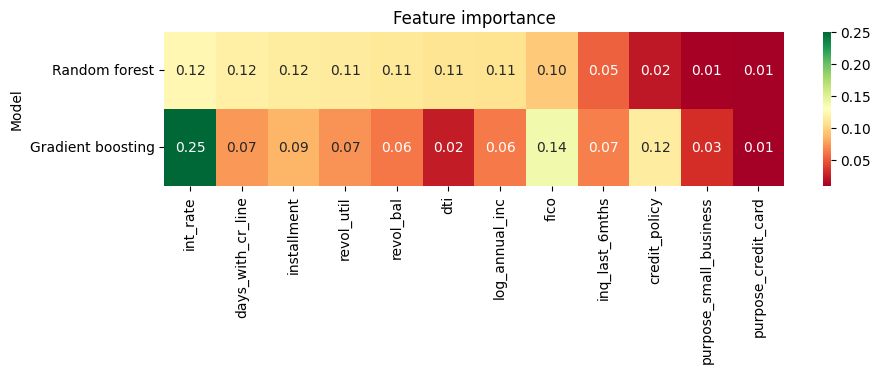

In [70]:
# Correlation of numerical attributes
plt.figure(figsize=(10, 2))
plt.title('Feature importance')
sns.heatmap(model_rank, annot=True, fmt='.2f', cmap='RdYlGn')
plt.yticks(rotation=360)
plt.show()

Although feature importance ranking differs between Random Forest vs Gradient boosting, we see close resemblance with previous EDA observations where loans not fully paid is largely correlated to interest rate, number of inquiries by creditors in the last 6 months, revolving balance, credit policy and FICO.  

Text(0.5, 1.0, 'Random forest Model - Partial plot')

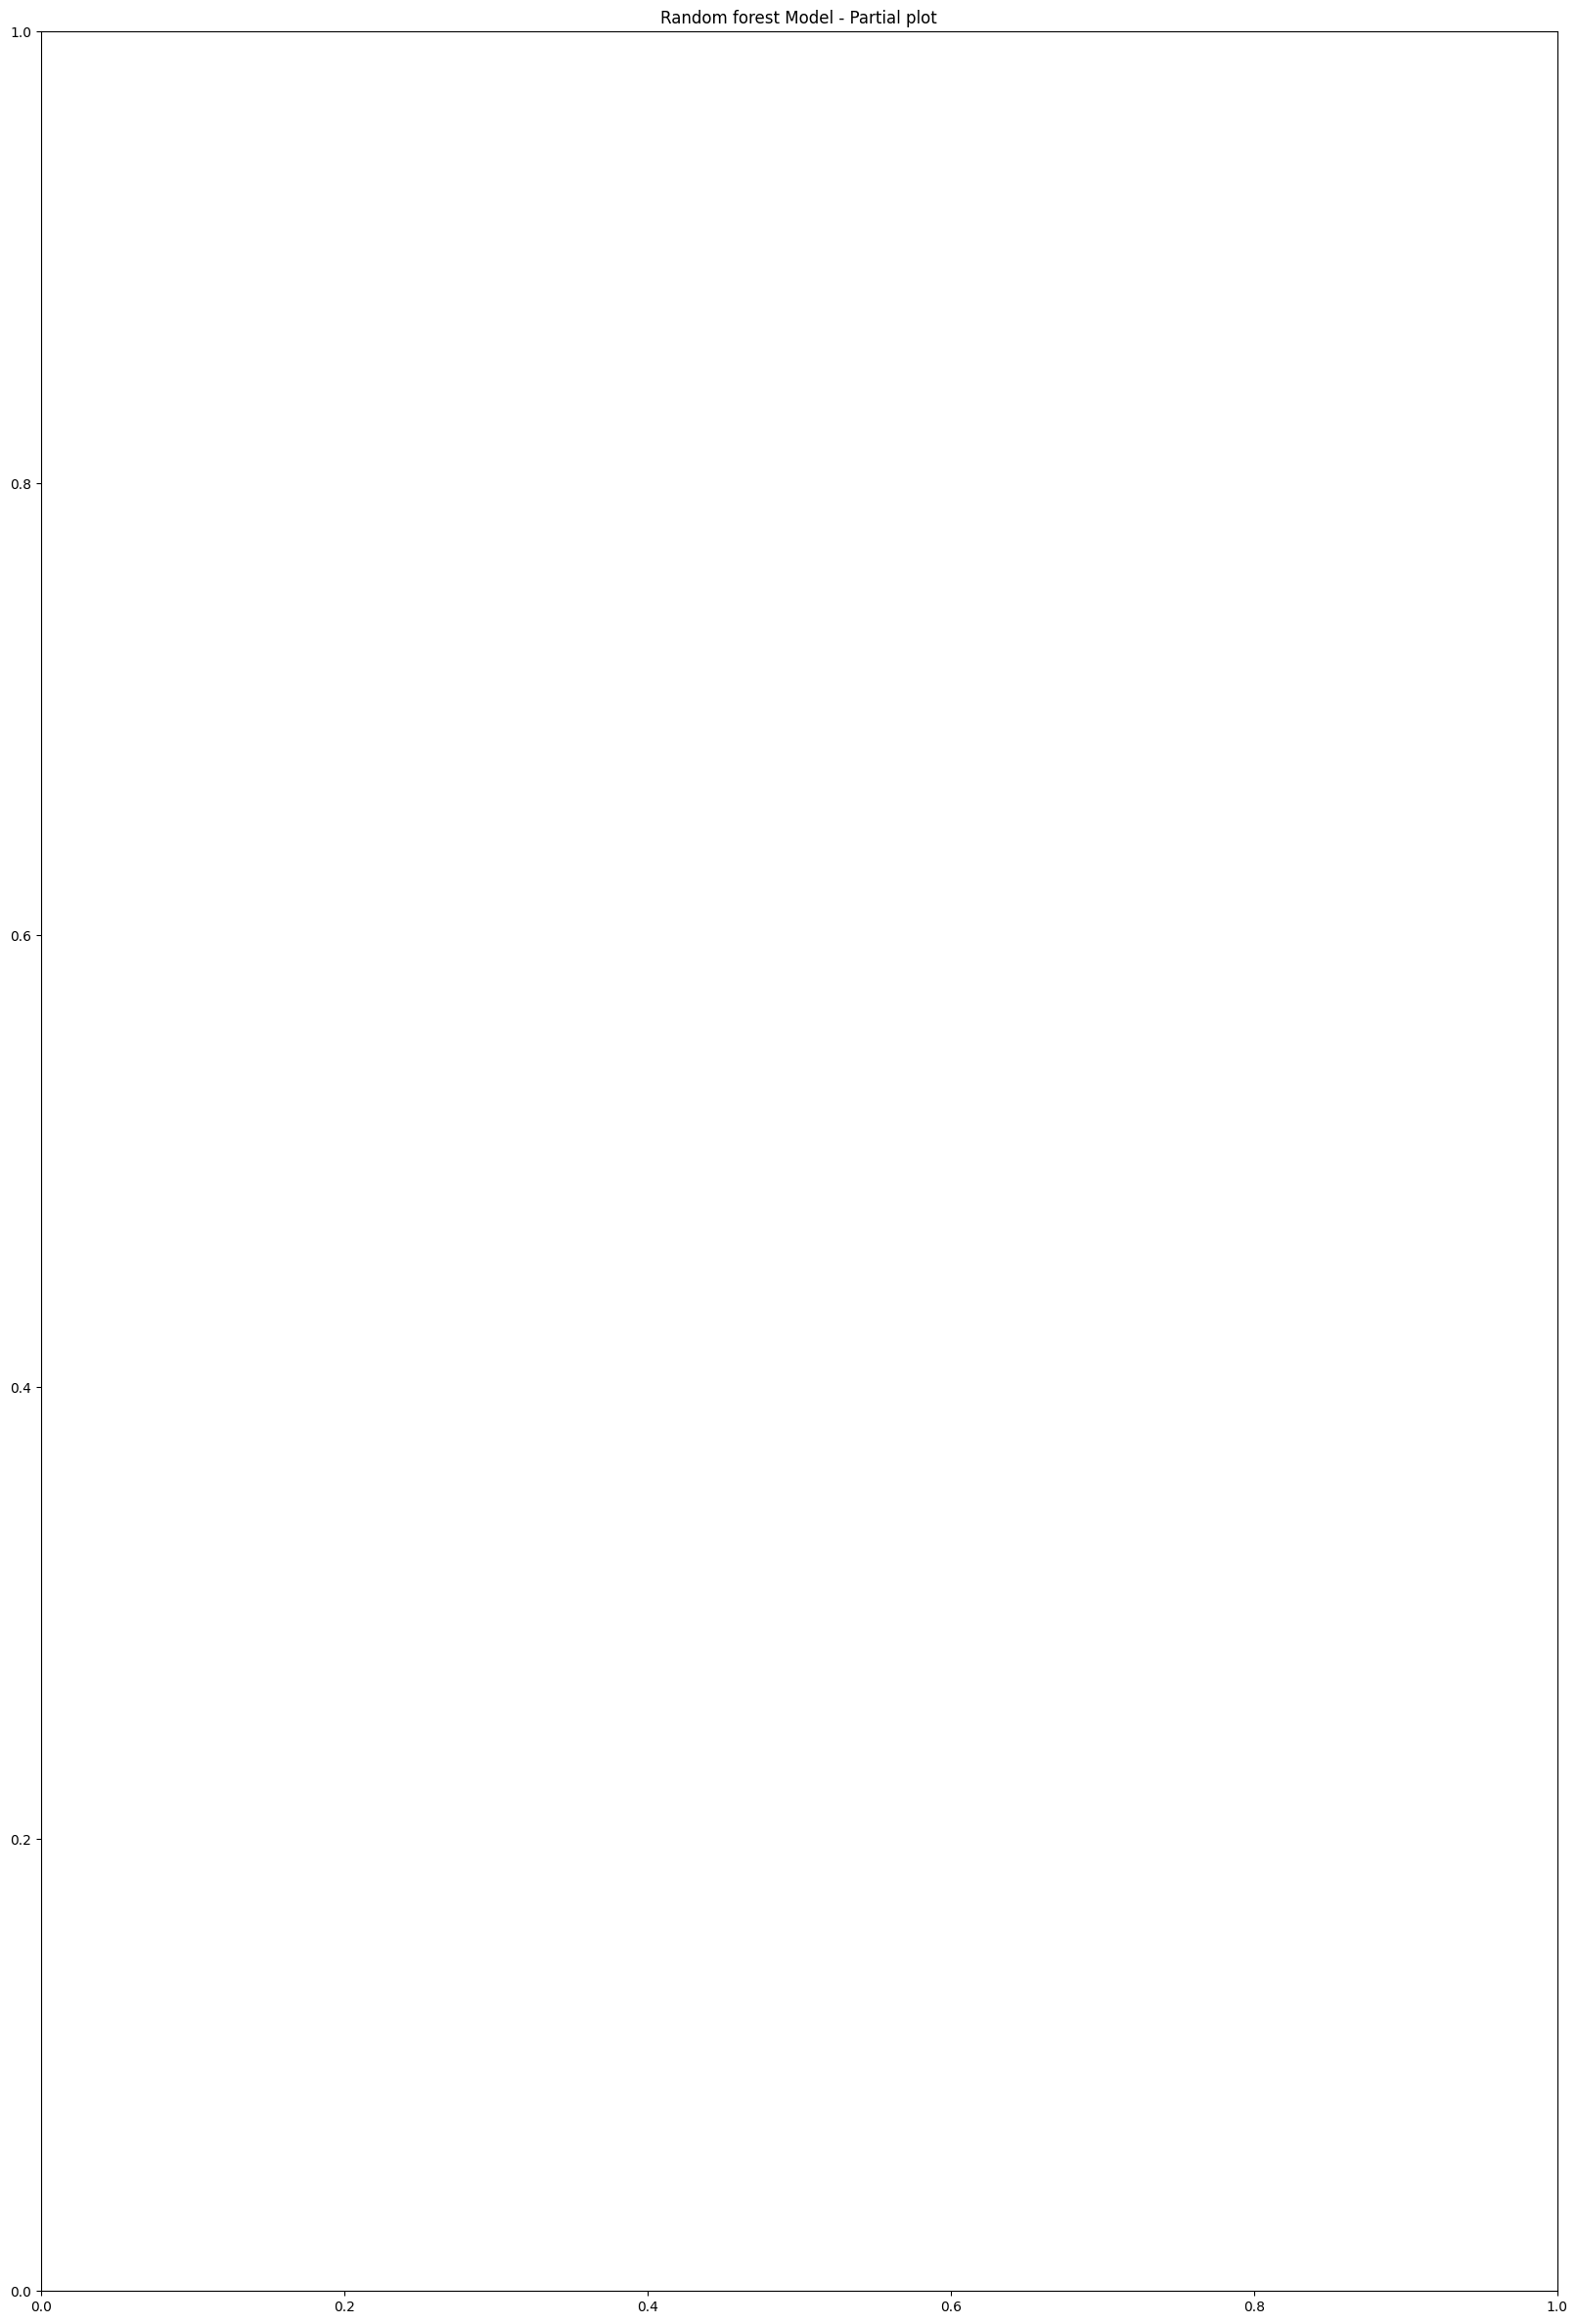

In [71]:
# Partial plot
fig, ax = plt.subplots(figsize=(20, 30))
ax.set_title("Random forest Model - Partial plot")
#tree_disp = plot_partial_dependence(rfe_rf, X_train, list(range(0, 18)), ax=ax)
# tree_disp = plot_partial_dependence(rf, X_train_mask, list(range(0, 11)), ax=ax)

From the plots, we see once again that loans with high interest rates, high FICO score and client with large number of inquiries tend to have higher loans unpaid. 

This aligns with our real life understanding where clients with bad credit scoring are generally charged higher interest rate so that the lender can better protect itself from potential defaults. Moreover, clients with bad credit scoring might also be actively seeking credit lines, thus the large number of inquiries into their accounts.


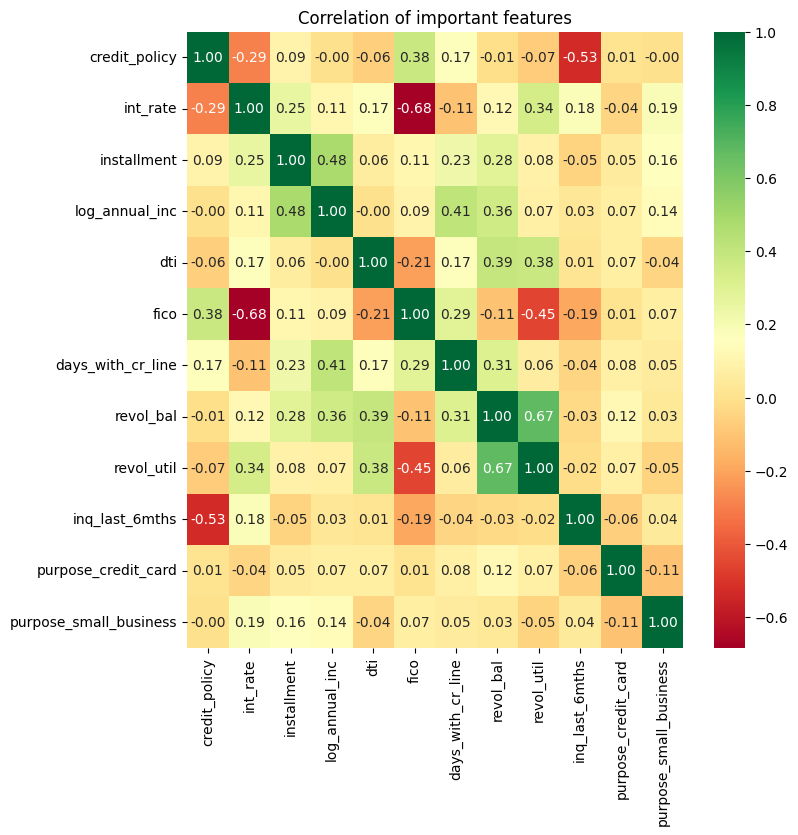

In [72]:
# Correlation of numerical attributes
plt.figure(figsize=(8, 8))
plt.title('Correlation of important features')
sns.heatmap(X_train_mask.corr(), annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Based on the above, we see that none of the selected features exhibit multi-collinearity.   

In [73]:
# Define list to store result 
final_result = list()
# Define list to store result 
final_model = list()
def model_run(model, clf, X=X_test, y=y_test):

    # Evaluate error rates and append to lists
    y_test_predict = clf.predict(X)
    auc = roc_auc_score(y, y_test_predict)
    precision =precision_score(y, y_test_predict)
    recall = recall_score(y, y_test_predict)
    accuracy = clf.score(X, y)

    # Print classification report
    print(f'== {model} - Classification report ==')
    print(classification_report(y, y_test_predict))
    
    # Plot confusion matrix
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_test_predict)), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'{model}- Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')   
    plt.show()
    
    # Plot ROC curve
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X)[:,1]
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds= roc_curve(y_test, y_pred_prob)
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.plot(fpr, tpr, marker='.', label=model)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model} - ROC curve')
    plt.annotate(f'AUC ={round(auc, 5)} ', xy=(0.7, 0.5),fontsize=12,)
    # show the legend
    plt.legend()    
    plt.show()
    
    # Plot precision recall curve
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred_prob)
    # Random classifier is one which randomly predicts a class and is the ratio of the ones in the dataset
    random_clf = y_test[y_test==1].count() / len(y_test) #len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [random_clf, random_clf], linestyle='--', label='Average precision')
    plt.plot(recall_, precision_, marker='.', label=model)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model} - Precision recall curve')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

    return {'Model':model, \
            'Accuracy': round(accuracy,5) , \
            'Precision':round(precision,5) , \
            'Recall':round(recall,5), \
            'AUC':round(auc,5)}

### 5. Modelling   

To improve model’s prediction capability and to overcome common problems associated with imbalanced dataset, various techniques are researched. We shortlisted the proposed improvements in the section below.      
1.	K-fold cross validation    
Up-sampling is usually done during model training to overcome imbalance class. However, up-sampling can cause overfitting. Thus, k-fold cross validation will be used because this method is more superior than the simple train/test split to prevent overfitting. In addition, K=5 is chosen because empirical data showed that this value produces lower error rate and has a balanced bias vs variance (An Introduction to Statistical Learning, 2017).         
2.	Stratification   
Due to class imbalance, for k-fold cross validation, we might end up with folds which has no representation from the minority class (Jason Brownlee, 2020). Hence, stratification will be applied to ensure that the original class distribution is maintained in each fold.    
3.	SMOTE method     
If up-sampling is done before cross validation, we risk data leak traps since the same up-sampled data might appear in both the training and validation folds. Hence, SMOTE method will be used to segregate the data into its respective folds before up-sampling is done in each fold. SMOTE is selected because of its low chances of overfitting and information loss. (Nitesh, 2002)    
4.	Log transformation and Data scaling   
Features in our dataset are skewed and have high variance. Such high variance will negatively impact the accuracy of the model. Thus, log transformation is done to reduce features’ variance. For features with minimum value of zero, 1 is added before taking log to prevent infinity values. Thereafter, Z-score normalization is done so that features are compared on a similar scale.    
5.	Hyper-parameter tunning    
Hyper-parameters must be tuned to overcome bias-variance trade off in the models.   
For example, in Random Forest, when the number of trees is low at the extreme left, underfitting results in high bias, thus high errors. As number of trees is increased towards the right side of the graph, overfitting sets in, resulting in low training error but increasing validation error. Thus, hyper-parameters must be fine-tuned to select the best param which prevent overfitting and underfitting. 
The hyper-parameters will be fine-tunned using GridSearchCV. 




### 5.1 Logistic regression (with feature selection)    
Based on the features selected in the feature selection selection, we now run the logistic regression model to see if performance has improved.

      credit_policy  int_rate  installment  log_annual_inc       dti  \
3343       0.491133 -0.121692    -2.209296       -0.183343  0.654820   
9          0.491133 -0.001936    -1.500427       -1.203518 -0.015136   
1741       0.491133  1.733017     1.413966        1.590433  0.376723   
5160       0.491133  1.890486     0.169294        0.403591  0.850441   
7760      -2.036108  0.336761    -0.305635       -2.524781 -0.997500   
6261       0.491133 -0.144184    -1.273984       -0.483632  0.454801   
390        0.491133 -1.458210    -0.399214       -0.542887  0.267624   
8943      -2.036108 -1.096085    -0.932783        0.929802  0.079453   
7695       0.491133  1.264285     1.389134        0.883530 -1.218886   
4041       0.491133 -0.977343     0.783051        0.338743  0.464590   

          fico  days_with_cr_line  revol_bal  revol_util  inq_last_6mths  \
3343 -0.625785          -0.860807  -0.821995    0.612489       -1.062034   
9    -0.082211          -0.589243   0.001688   -0.29679

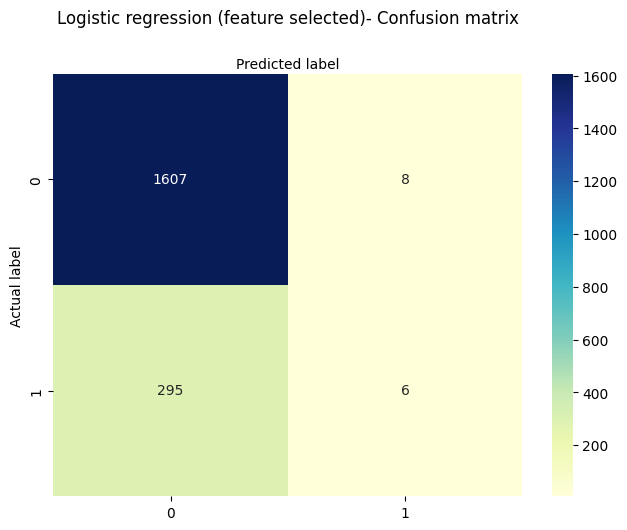

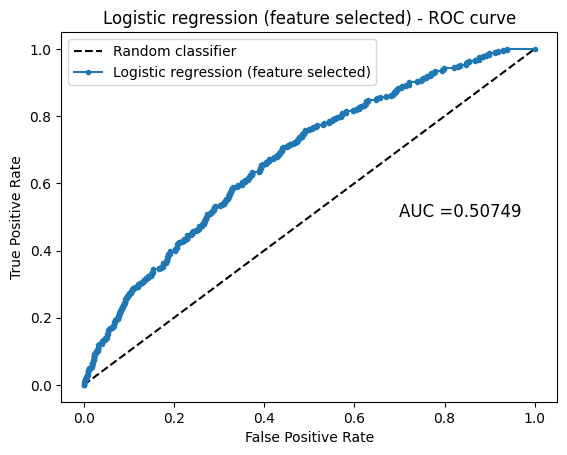

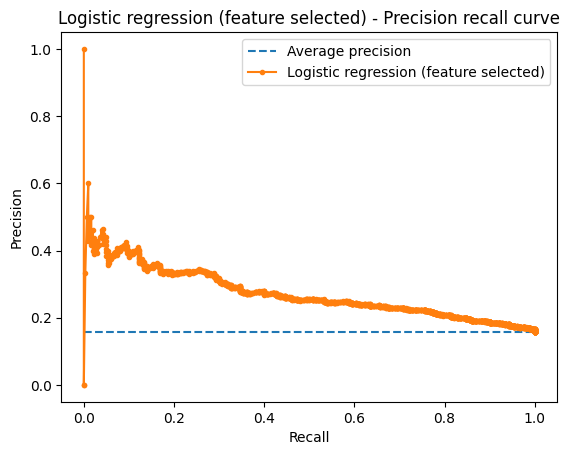

In [91]:
# Logistic regression v1 (baseline)
clf = LogisticRegression()
print(X_test_e_l_n.head(10))
clf.fit(X_train_e_l_n, y_train)
final_model.append(model_run('Logistic regression (feature selected)', clf, X=X_test_e_l_n, y=y_test))

### 5.2 Logistic regression (improved)    
Next, we apply further improvements (k-fold cross validation to improve overfitting, SMOTE to overcome imbalance class, stratification to prevent data leaks during cross validation) to better the performance of the basic logistic regression.


In [75]:
# Initialise kfold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
def best_param_search(model, pipe, new_params,kf):
    # Run search for best param

    clf = GridSearchCV(pipe, param_grid=new_params, cv=kf, scoring='roc_auc',
                            return_train_score=True)
    # Fit to model with best hyper-param
    clf.fit(X_train_e_l_n, y_train)
    # Print best results
    clf.cv_results_['mean_test_score'], clf.cv_results_['mean_train_score']
    # Best score 
    clf.best_score_
    # Best param
    clf.best_params_
    # Print test result
    y_test_predict = clf.best_estimator_.predict(X_test_e_l_n)
    score = roc_auc_score(y_test, y_test_predict)
    
    # Print all stats
    # final_model.append(model_run(model, clf, X=X_test, y=y_test))

    #return clf.best_params_, score 
    return clf, {'Model':model, 'Best hyperparam': clf.best_params_, 'AUC':round(score,5)}
    #return {'Model':model, 'AUC':round(score,5)}

### 5.3 Random forest (improved)    
Finally, we attempted the Random forest model (with k-fold cross validation to improve overfitting, SMOTE to overcome imbalance class, stratification to prevent data leaks during cross validation) to see if our model can be further improved. 

== Logistic Regression (improved) - Classification report ==
              precision    recall  f1-score   support

           0       0.90      0.62      0.73      1615
           1       0.23      0.62      0.34       301

    accuracy                           0.62      1916
   macro avg       0.56      0.62      0.53      1916
weighted avg       0.79      0.62      0.67      1916



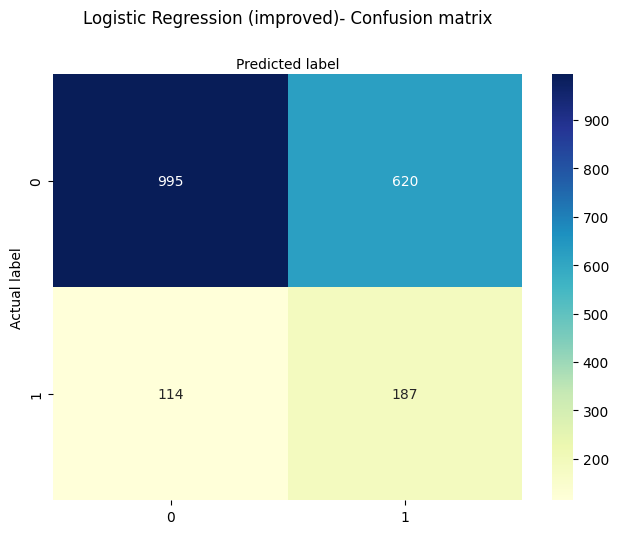

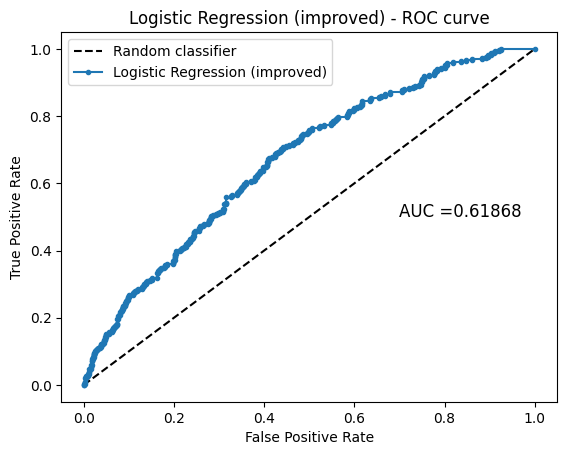

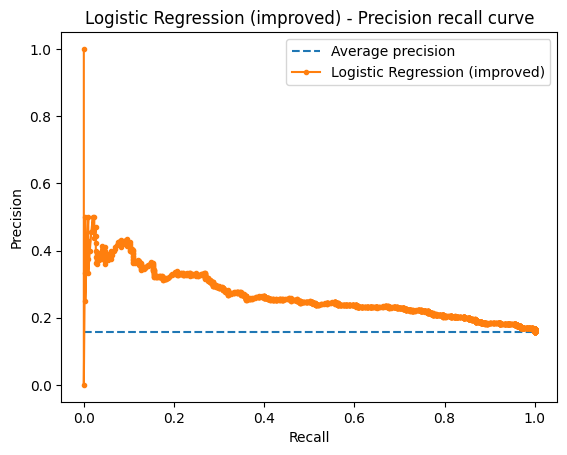

[{'Model': 'Logistic regression (feature selected)',
  'Accuracy': 0.84186,
  'Precision': 0.42857,
  'Recall': 0.01993,
  'AUC': 0.50749},
 {'Model': 'Logistic Regression (improved)',
  'Accuracy': 0.67052,
  'Precision': 0.23172,
  'Recall': 0.62126,
  'AUC': 0.61868}]

In [76]:
### Logistic regression 
penalty = ['l1','l2','elasticnet','none']
c_values = np.logspace(-7, 1, 10)
# Define params
params = {
    'penalty': penalty,
    'C': c_values,
    'random_state': [0]
}
new_params = {'logisticregression__' + key: params[key] for key in params}

# Create pipeline
pipe = make_pipeline(SMOTE(random_state=42), 
                              LogisticRegression(penalty='l1' ,C=0, random_state=0))
# Search for best param
lr_clf, lr = best_param_search('Logistic Regression (improved)', pipe, new_params,kf)
# Print result
final_model.append(model_run('Logistic Regression (improved)', lr_clf, X=X_test_e_l_n, y=y_test))
# Append result
final_result.append(lr)
final_result
final_model

In [77]:
### Random forest 
n_estimators = np.linspace(600,800, num=10)
# Define rf params
params = {
    'n_estimators': [int(x) for x in n_estimators],
    'max_depth': [5, 15, 20],
    'random_state': [0]
}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
# Create pipeline
pipe = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=375, random_state=0))
# Search for best param
rf_clf, rf = best_param_search('Random forest (improved)', pipe, new_params,kf)
# Print result
final_model.append(model_run('Random forest (improved)', rf_clf, X=X_test_e_l_n, y=y_test))

# Append result
final_result.append(rf)
final_result
final_model

KeyboardInterrupt: 

In [ ]:
# Present result in table 
final_model_df = pd.DataFrame(final_model)
final_model_df.set_index('Model', inplace=True)
#final_model_df.head()

In [ ]:
# Print model label
index = ['Model 1','Model 2','Model 3']
conclusion = final_model_df.copy()
conclusion['No.'] = index
conclusion.reset_index(inplace=True)
conclusion.set_index('No.',inplace=True)
conclusion

ValueError: Length of values (3) does not match length of index (2)

In [ ]:
# Rename col
conclusion.rename(columns={'Model':'Description'}, inplace=True)
#conclusion

In [ ]:
conclusion

As discussed before, with Recall as the most important performance metric, we will select Model 2 - Logistic regression (improved) model as the final model.    


### 6. Storing model

In [ ]:
# Save the model as a pickle in a file 
joblib.dump(clf, 'clf.pkl')


# Load the model from the file 
# lr_from_joblib = joblib.load('model.pkl') 
  
# Use the loaded model to make predictions 
# knn_from_joblib.predict(X_test)

### 7. Conclusion   

In this exercise, we proved the hypothesis that with the client's loan history and credit records, the lender will be able to predict the chances of a non-full payment from the client's loan. Also, with further model improvement techniques such as feature selection, k-fold cross validation to improve overfitting, SMOTE to overcome imbalance class, stratification to prevent data leaks during cross validation, our Recall can be improved significantly to 62% from 2% for the Logistic regression model. 

Moving forward, we can also experiment with other more complex models e.g., neural network to improve the performance of our model.
